# **Full Fine-Tuning with Fully Sharded Data Parallel (FSDP)**

### **Full Fine-Tuning with Fully Sharded Data Parallel Readme:**

For more information on Full Fine-Tuning with Fully Sharded Data Parallel, refer to the [Full Fine-Tuning with Fully Sharded Data Parallel Readme](../full_finetuning_with_fsdp_readme.md).

### **About This Notebook:**

This notebook demonstrates `Full Fine-Tuning with Fully Sharded Data Parallel`. Compared to the [Full Fine-Tuning Notebook](../../2.4_full_finetuning/run_1_a100_80g_x1/full_finetuning.ipynb), the following modifications have been made:

1. User does not need to set `device_map` (it is set to `None` in this notebook). Instead, the Hugging Face library leverages PyTorch's Fully Sharded Data Parallel to automatically shard model parameters across GPUs based on the accelerate configuration file (`my_accelerate_config.yaml`), eliminating the need for an explicitly defined `device_map` during multi-GPU training. During FSDP training, multiple ranks (processes) are initiated in parallel, with each rank allocating its sharded model layers to the GPU it is bound to. Specifically, once FSDP training starts and during the first forward pass (e.g., model evaluation or model training), the trainer's internal accelerator not only initializes an optimizer and moves it to the designated GPU but also shards the model weights and moves them to the appropriate GPU. At this point, the module becomes wrapped and located on the GPU. Please note that if inference is run before the first training step, since `device_map` is set to `None`, the model must be manually moved to the GPU(s) before running inference.

2. Two accelerators are used in each rank (process):
   - `The first accelerator` is initialized at the beginning of each rank (process). This `utility accelerator` is used for read-only operations, such as providing the current rank (process) ID to help bind the rank to its corresponding GPU. It also uses the `wait_for_everyone()` function to synchronize across ranks.
   - `The second accelerator` is initialized by the trainer when specific conditions are detected, such as multi-GPU or distributed training, mixed-precision training, or gradient accumulation. This trainer's `internal accelerator` moves dataloaders from CPU to GPU (via `prepare()`) after the trainer is set up and moves the model (weights and gradients) and optimizer to the GPU once training starts. 
   - Both accelerators share the same `AcceleratorState`, which inherits the distributed setup (process group, device mapping, etc.) from the environment variables or initialization process specific to the launcher used (e.g., `notebook_launcher` or `accelerate launch`).

3. An optional custom callback function is defined to validate that layer sharding is evenly distributed across GPUs in FSDP. During the first training step, the percentage of parameters sharded on each GPU is printed to confirm that layer sharding is evenly distributed across GPUs. Additionally, this callback reports VRAM usage and prints details of the mini-batch dispatched to the current rank, including the mini-batch size and the first data in the mini-batch. These details ensure that each rank (GPU) processes a distinct batch of data from the dataset, verifying proper data parallelism.

4. Full fine-tuning-related pre-training and training steps are encapsulated in a workflow function. The following modifications were made to support FSDP:  
   4.1. Initialize a utility accelerator to provide the current rank (process) ID, which helps bind the current rank to its corresponding GPU.  
   4.2. Override the `print()` function to prepend a prefix string. This ensures individual rank outputs can be identified even when all ranks' outputs are mixed in the terminal, facilitating debugging.  
   4.3. Use only the main rank (rank 0, GPU 0) for specific tasks such as account logins, file writing, and model inference to avoid redundant logins and file conflicts in multi-process environments.  
   4.4. Set `use_fsdp=True` to apply additional trainer configurations for FSDP. This disables gradient checkpointing-related settings in `TrainingArguments` and uses `activation_checkpointing` from the accelerate configuration instead.  
   4.5. Scale up the learning rate for multi-GPU training. Typically, the learning rate increases proportionally with the batch size. In this notebook, the effective batch size for multi-GPU training scales linearly with the number of GPUs allocated for training. For 2 A100 GPUs, the effective batch size is `14 * 2 = 28`, and for 4 A6000 GPUs, the effective batch size is `10 * 4 = 40`. Additionally, the square root scaling rule (instead of the linear scaling rule) is used for learning rate adjustment to ensure better stability. In the [Full Fine-Tuning Notebook](../../2.4_full_finetuning/run_1_a100_80g_x1/full_finetuning.ipynb), single GPU training uses `batch_size=10` and `learning_rate=1e-5`. For 2 A100 GPUs, the scaled learning rate is calculated as `scaled_learning_rate = sqrt(28/10) * learning_rate = 1.7e-5`. Similarly, for 4 A6000 GPUs, the scaled learning rate is `scaled_learning_rate = sqrt(40/10) * learning_rate = 2e-5`.

5. Since the training workflow function is saved in an external Python file, removing the Python cache folder (`__pycache__`) and restarting the kernel after modifying the workflow content ensures that the notebook does not pick up old cached content.

6. Two approaches are demonstrated to execute the training workflow function: using `notebook_launcher` or `accelerate launch`.

7. During training, the `save_state()` function is called to save the model checkpoint (weights) in a `sharded-state`. After training, the fine-tuned model is loaded from the checkpoint with the minimum loss by merging the `sharded-state` checkpoint weights into the `full-state` base model weights. Please note that it is crucial to ensure the `state_dict` (whether in `sharded-state` or `full-state`) is consistent across all GPUs. Mixing some GPUs in `sharded-state` and others in `full-state` can lead to unexpected behavior.

### **Supporting Python and YAML Files:**

- `my_login.py`: Contains reusable login functions (e.g., for Hugging Face and Weights & Biases). Created in the [Complete LoRA Fine-Tuning Notebook](../../2.1_lora_finetuning/run_1_a6000_48g_x1/lora_finetuning_complete.ipynb).
- `my_utils.py`: Contains general-purpose utility functions for fine-tuning. Created in the [Complete LoRA Fine-Tuning Notebook](../../2.1_lora_finetuning/run_1_a6000_48g_x1/lora_finetuning_complete.ipynb).
- `my_utils_full_finetuning_with_fsdp.py`: Contains utility functions specific to full fine-tuning with Fully Sharded Data Parallel. Created within this notebook.
- `my_workflow_full_finetuning_with_fsdp.py`: Contains a workflow function that encapsulates full fine-tuning-related pre-training and training steps, along with the modifications required for FSDP. Created within this notebook.
- `my_accelerate_config.yaml`: Contains accelerate configuration for FSDP. Created within this notebook.

### **Experiment Settings:**

This experiment is conducted within a pod (container instance) provided by [RunPod](https://runpod.io). The specific configurations are as follows:

- `Template (Docker Container Image)`: runpod/pytorch:2.4.0-py3.11-cuda12.4.1-devel-ubuntu22.04
- `Volume Disk`: 2000GB (model checkpoints storage)
- `GPU Setup`: 4 Nvidia A6000 GPUs (48GB VRAM)


---
# **Step 1: Preparation**

## 1.1 Install Necessary Python Packages

In [1]:
!python -m pip install -q -U pip            # [optional] upgrade pip
!pip install huggingface_hub==0.25.1 -q -U  # hf lib to login to huggingface and download dataset, model
!pip install hf_transfer==0.1.8 -q -U       # hf lib to speed up huggingface data transfer 
!pip install transformers==4.46.0 -q -U     # hf lib to load model and processor(tokenizer)
!pip install accelerate==0.34.2 -q -U       # hf lib to support 'device_map', restart kernel required after installation
!pip install flash-attn==2.6.3 -q -U        # to reduce vram usage for llama model, restart kernel recommended after installation
!pip install datasets==3.0.0 -q -U          # hf lib to load dataset
!pip install peft==0.13.0 -q -U             # hf lib to support lora fine-tuning
!pip install matplotlib==3.9.2 -q -U        # to plot similarity score comparison graphs
!pip install tensorboard==2.18.0 -q -U      # to support logging with tensorboard
!pip install wandb==0.18.1 -q -U            # to support logging with weights and biases (wandb)
!pip install ipython==8.28.0 -q -U          # to enable %% magic functions in a jupyter notebook


Reason for being yanked: This version unfortunately does not work with 3.8 but we did not drop the support yet


## 1.2 Restart Kernel to Activate Installed Packages

---
# **Step 2: Pre-training & Training**

## 2.1 Create an Accelerate Configuration File for Fully Sharded Data Parallel Training  

In this notebook, we create an accelerate configuration file (`my_accelerate_config.yaml`) based on below considerations:  

1. Full fine-tuning is trained on 1 node (computer) with 2 A100 or 4 A6000 GPUs.  

2. Choose PyTorch Fully Sharded Data Parallel (`FULL_SHARD`) for training, which shards parameters, gradients, and optimizer states, and is equivalent to Deepspeed ZeRO Stage 3.  

3. For model shard (wrap) strategy:  
    3.1. `model._no_split_modules` prevents specified modules from being split across shards during parallel training and can influence model wrapping in FSDP. However, in this notebook, we don't leverage it for model sharding. Instead, we use `fsdp_auto_wrap_policy` and `fsdp_transformer_layer_cls_to_wrap` to control model wrapping and sharding.  
    3.2. Attn and MLP layers will be sharded by listing their class names in `fsdp_transformer_layer_cls_to_wrap`. Norm layers are not sharded due to their small sizes. Also, Embedding layers are not sharded since leaving full Embedding layers on each GPU helps reduce cross-GPU communication costs during training.  

4. In order to maximize GPU utilization:  
    4.1. Parameters and gradients are not offloaded to CPU.  
    4.2. Prefetch is enabled on both forward and backward passes to reduce time spent on waiting for shards.  

5. In order to minimize GPU VRAM usage:  
    5.1. Model state (model checkpoint) is stored in a sharded state during training. Along with the included metadata, we can recover full-state model weights from the sharded-state weights for model saving.  
    5.2. When parameters are inactive, for instance, training on the current wrapper (layer) is complete, for computing efficiency, `use_orig_params` still reserves a full-size VRAM for inactive parameters, although only a sharded part is needed to be kept in VRAM. We disable `use_orig_params` so that only the required sharded part of inactive parameters will be kept in VRAM, and the rest of the reserved VRAM can be released to other wrappers (layers) for active computations.  
    5.3. Enable activation checkpoint: Not all intermediate activations are stored. Instead, we only store a few as checkpoints, and the missing ones are recomputed on the fly during the backward pass.  

6. For model loading:  
    6.1. Use two-stage model loading to avoid OOM (out-of-memory) errors.  
        - `Two-stage model loading`: The model is loaded progressively from the source to CPU RAM and then to GPU VRAM. During this process, each wrapper is fully loaded into CPU RAM first, then split and distributed across GPUs (e.g., GPU0, GPU1, GPU2).  
        - `One-stage model loading`: The model is loaded directly from the source to GPU VRAM. During progressive loading, each wrapper needs to be fully loaded on GPU0 VRAM before being split and distributed to GPU0, GPU1, GPU2, which can lead to OOM issues on GPU0.  
        
    6.2. Enable `fsdp_sync_module_states`: The same model component may demonstrate different weights across multiple GPUs due to, for instance, random initialization using a normal distribution. With synchronization, all GPUs are ensured to be initialized with the same weights before training begins.  

7. In order to stabilize training: Set `mixed_precision` to `fp16`. [Link1](https://huggingface.co/blog/deepspeed-to-fsdp-and-back) and [Link2](https://huggingface.co/docs/accelerate/concept_guides/fsdp_and_deepspeed) suggest choosing `mixed_precision` to `fp16` in FSDP, which will automatically upcast precision to `fp32` during training for improved stability.  


There are two approaches to create an accelerate configuration file for FSDP: `directly edit` or use the `accelerate config` command.  

### **(Approach 1) Directly Edit an Accelerate Configuration File:**

In [1]:
# Define the accelerate configuration as a dictionary
accelerate_config = {
    "compute_environment": "LOCAL_MACHINE",
    "debug": False,
    "distributed_type": "FSDP",
    "downcast_bf16": "no",
    "enable_cpu_affinity": False,
    "fsdp_config": {
        "fsdp_activation_checkpointing": True,
        "fsdp_auto_wrap_policy": "TRANSFORMER_BASED_WRAP",
        "fsdp_backward_prefetch": "BACKWARD_PRE",
        "fsdp_cpu_ram_efficient_loading": True,
        "fsdp_forward_prefetch": True,
        "fsdp_offload_params": False,
        "fsdp_sharding_strategy": "FULL_SHARD",
        "fsdp_state_dict_type": "SHARDED_STATE_DICT",
        "fsdp_sync_module_states": True,
        "fsdp_transformer_layer_cls_to_wrap": "Idefics2VisionFlashAttention2,Idefics2VisionMLP,Idefics2MLP,Idefics2PerceiverFlashAttention2,MistralFlashAttention2,MistralFlashAttention2,MistralMLP",
        "fsdp_use_orig_params": False
    },
    "machine_rank": 0,
    "main_training_function": "main",
    "mixed_precision": "bf16",
    "num_machines": 1,
    "num_processes": 4,
    "rdzv_backend": "static",
    "same_network": True,
    "tpu_env": [],
    "tpu_use_cluster": False,
    "tpu_use_sudo": False,
    "use_cpu": False
}

# Write the accelerate configuration to a YAML file
import yaml
with open("./my_accelerate_config.yaml", 'w') as f:
    yaml.dump(accelerate_config, f)

### **(Approach 2) Use `accelerate config` to Create an Accelerate Configuration File:**

Execute the command `accelerate config --config_file './my_accelerate_config.yaml'` in a terminal, then follow the prompts below to create an accelerate configuration YAML file:

In which compute environment are you running? -> `This machine`  
Which type of machine are you using? -> `multi-GPU`  
How many different machines will you use (use more than 1 for multi-node training)? -> `1`  
Should distributed operations be checked while running for errors? This can avoid timeout issues but will be slower. -> `NO`  
Do you wish to optimize your script with torch dynamo? -> `NO`  
Do you want to use DeepSpeed? -> `NO`  
Do you want to use FullyShardedDataParallel? -> `yes`  
What should be your sharding strategy? -> `FULL_SHARD`  
Do you want to offload parameters and gradients to CPU? -> `NO`  
What should be your auto wrap policy? -> `TRANSFORMER_BASED_WRAP`  
Do you want to use the model's _no_split_modules to wrap. -> `NO`  
Specify the comma-separated list of transformer layer class names (case-sensitive) to wrap -> `Idefics2VisionFlashAttention2,Idefics2VisionMLP,Idefics2MLP,Idefics2PerceiverFlashAttention2,MistralFlashAttention2,MistralFlashAttention2,MistralMLP`  
What should be your FSDP's backward prefetch policy? -> `BACKWARD_PRE`  
What should be your FSDP's state dict type? -> `SHARDED_STATE_DICT`  
Do you want to enable FSDP's forward prefetch policy? -> `yes`  
Do you want to enable FSDP's use_orig_params feature? -> `no`  
Do you want to enable CPU RAM efficient model loading? -> `YES`  
Do you want to enable FSDP activation checkpointing? -> `yes`  
How many GPU(s) should be used for distributed training? -> `4`  
Do you wish to use mixed precision? -> `bf16`  


## 2.2 Define Utility Functions for Full Fine-Tuning with Fully Sharded Data Parallel

In [2]:
%%writefile my_utils_full_finetuning_with_fsdp.py
#--------------- Functions in Full Fine-Tuning with Fully Sharded Data Parallel ---------------
# 1) Override the built-in print() function to prepend a prefix string to all printed messages.
import builtins
def add_prefix_to_print_function(prefix_string):
    original_print = builtins.print                               # Save a reference to the original print function
    def custom_print(*args, **kwargs):                            # Define a custom print function
        args = (f"{prefix_string} {' '.join(map(str, args))}",)   # Prepend the prefix string to the original print message
        original_print(*args, **kwargs)                           # Call the original print function with the modified arguments
    builtins.print = custom_print                                 # Override the built-in print function

# 2) Print utility accelerator info to the terminal
def print_util_accelerator_info(accelerator):
    print(f'==> Printing utility accelerator info...')
    print(f'==> accelerator.distributed_type: {accelerator.distributed_type}')                                 # Current distributed training mode: FSDP
    print(f'==> accelerator.state.num_processes: {accelerator.state.num_processes}')                           # Total number of processes across all devices
    print(f'==> accelerator.state.process_index: {accelerator.state.process_index}')                           # Global index of the current process among all device processes
    print(f'==> accelerator.state.local_process_index: {accelerator.state.local_process_index}')               # Local index of the current process on its assigned device
    print(f'==> accelerator.state.device: {accelerator.state.device}')                                         # Device assigned to the current process
    print(f'==> accelerator.state.mixed_precision: {accelerator.state.mixed_precision}')                       # Precision mode used for training (e.g., FP16, BF16, FP32)
    if hasattr(accelerator.state, 'fsdp_plugin'):                                                              # Details of the FSDP plugin, if configured
        print(f'==> accelerator.state.fsdp_plugin: {accelerator.state.fsdp_plugin.__dict__}')
    else:
        print(f'==> accelerator.state.fsdp_plugin: Not Specified')

# 3) Print trainer info to the terminal
def print_trainer_info(trainer):
    print(f'==> Printing trainer info...')
    # Print trainer.model 
    print(f'==> trainer.model is located on device: {next(trainer.model.parameters()).device}')                # Device where the model is located
    # Print trainer.accelerator internal state 
    accelerator = trainer.accelerator       
    print(f'==> trainer.accelerator.distributed_type: {accelerator.distributed_type}')                         # Current distributed training mode: FSDP
    print(f'==> trainer.accelerator.state.num_processes: {accelerator.state.num_processes}')                   # Total number of processes across all devices
    print(f'==> trainer.accelerator.state.process_index: {accelerator.state.process_index}')                   # Global index of the current process among all device processes
    print(f'==> trainer.accelerator.state.local_process_index: {accelerator.state.local_process_index}')       # Local index of the current process on its assigned device
    print(f'==> trainer.accelerator.state.device: {accelerator.state.device}')                                 # device assigned to the current process
    print(f'==> trainer.accelerator.state.mixed_precision: {accelerator.state.mixed_precision}')               # Precision mode used for training (e.g., FP16, BF16, FP32)
    if hasattr(accelerator.state, 'fsdp_plugin'):                                                              # Details of the FSDP plugin, if configured
        print(f'==> trainer.accelerator.state.fsdp_plugin: {accelerator.state.fsdp_plugin.__dict__}')
    else:
        print(f'==> trainer.accelerator.state.fsdp_plugin: Not Specified')
    # Print trainer.train_dataloader
    train_dataloader = trainer.get_train_dataloader()
    print(f'==> trainer.train_dataloader: {train_dataloader}')                                                  # The dataloader used for training
    print(f'==> trainer.train_dataloader._is_accelerate_prepared: {train_dataloader._is_accelerate_prepared}')  # Whether the dataloader is prepared by accelerate
    print(f'==> trainer.train_dataloader.device: {train_dataloader.device}')                                    # Device assigned to the training dataloader
    # Print trainer.eval_dataloader
    eval_dataloader = trainer.get_eval_dataloader()
    print(f'==> trainer.eval_dataloader: {eval_dataloader}')                                                    # The dataloader used for evaluation
    print(f'==> trainer.eval_dataloader._is_accelerate_prepared: {eval_dataloader._is_accelerate_prepared}')    # Whether the dataloader is prepared by accelerate
    print(f'==> trainer.eval_dataloader.device: {eval_dataloader.device}')                                      # Device assigned to the evaluation dataloader
    # Print trainer.optimizer
    if trainer.optimizer:                                                                                       # Details of the optimizer, if defined
        optimizer = trainer.optimizer
        print(f'==> trainer.optimizer type: {type(optimizer)}')                                                 # Type of optimizer used
        print(f"==> trainer.optimizer.param_groups.initial_lr: {optimizer.param_groups[0]['initial_lr']}")      # Initial learning rate of the optimizer
        print(f'==> trainer.optimizer._is_accelerate_prepared: {optimizer._is_accelerate_prepared}')            # Whether the optimizer is prepared by accelerate
        print(f"==> trainer.optimizer on device: {optimizer.param_groups[0]['params'][0].device}")              # Device where the optimizer parameters are located
    else:
        print(f'==> trainer.optimizer is not available.') 

# 4) Print brief model wrapping status to the terminal and save detailed wrapping status to a file
# Note: This function is highly customized for the Idefics2 model
import os
import torch.distributed.fsdp as fsdp
def print_module_wrapping_status_to_file(model, filename):
    print(f'==> Printing module wrapping status...')
    filepath = os.path.dirname(filename)
    if not os.path.exists(filepath):
        os.makedirs(filepath)
    file = open(filename, 'w')

    # Define class names considered as module groups
    module_group_class_name = {
        'Idefics2ForConditionalGeneration', 
        'Idefics2Model', 
        'Idefics2VisionTransformer', 
        'Idefics2VisionEmbeddings',
        'Idefics2Encoder',
        'Idefics2EncoderLayer', 
        'Idefics2Connector', 
        'Idefics2PerceiverResampler',
        'ModuleList', 
        'MistralModel',
        'Idefics2PerceiverLayer', 
        'MistralDecoderLayer'
    }

    wrapped_module = 0
    unwrapped_module = 0
    # Iterate through model modules and categorize them
    for name, module in model.named_modules():
        if name == '':                                                                # Top-level module
            file.write(f'top_module:         {name} ({type(module).__name__})\n')
        elif type(module).__name__ in module_group_class_name:                        # Module group
            file.write(f'module group:       {name} ({type(module).__name__})\n')
        elif '._fsdp_wrapped_module' in name:                                         # FSDP-wrapped submodule
            file.write(f'                    {name}  ({type(module).__name__})\n')
        else:                                                                         # Regular module
            if isinstance(module, fsdp.FullyShardedDataParallel):                     # FSDP-wrapped module
                wrapped_module += 1
                file.write(f'--fsdp_wrap_module: {name} ({type(module).__name__})\n')
            else:                                                                     # Unwrapped module
                unwrapped_module += 1
                file.write(f'--unwrap-module:    {name} ({type(module).__name__})\n')

    # Calculate total modules and percentage of wrapped modules
    total_module = wrapped_module + unwrapped_module
    wrapped_percentage = (100 * wrapped_module / total_module) if total_module > 0 else 0
    print(f'==> Total modules: {total_module}, FSDP wrapped modules: {wrapped_percentage:.2f}%')
    print(f'==> For complete module wrapping status info, refer to {filename}')
    file.write(f'==> Total modules: {total_module}, FSDP wrapped modules: {wrapped_percentage:.2f}%\n')
    file.close()

# 5) Select Layers for Full Fine-Tuning
def select_layers_for_full_fine_tuning(model, module_list):
    print("==> Selecting Layers for Full Fine-Tuning...")
    for name, param in model.named_parameters():
        param.requires_grad = False                                                   # Freeze all parameters by default
        for module in module_list:
            if module in name and 'proj' in name:                                     # Set linear('proj') layers in the specified modules to trainable
                param.requires_grad = True
                break
    return model

# 6) Define a custom callback function to report VRAM usage, print mini-batch details, and display parameter sharding percentage on the current device.
# Note 1: At every training step, each GPU receives an individual mini-batch from the dataloader in FSDP. Printing the mini-batch size and the first data in the mini-batch at training step 1 helps validate that each GPU processes a different batch from the dataset, ensuring proper data parallelism.
# Note 2: At training step 1, printing the trainer's model type validates whether the model is FSDP-wrapped. Additionally, printing the percentage of parameters sharded on the current device validates that layer sharding is evenly distributed across GPUs.
import torch
from transformers import TrainerCallback
class CustomCallbackFSDP(TrainerCallback):
    def on_step_end(self, args, state, control, **kwargs):
        # If the current process is using a GPU and this is the first training step:
        if torch.cuda.is_available() and state.global_step == 1:
            # Report VRAM usage
            gpu_id = torch.cuda.current_device()
            gpu_memory = torch.cuda.memory_allocated(gpu_id) / (1024 ** 3)
            gpu_max_memory = torch.cuda.max_memory_allocated(gpu_id) / (1024 ** 3)
            total_memory = torch.cuda.get_device_properties(gpu_id).total_memory / (1024 ** 3)
            print(f'Step {state.global_step}: Current VRAM usage: {gpu_memory:.2f} GB, Peak VRAM usage: {gpu_max_memory:.2f} GB, Total GPU VRAM: {total_memory:.2f} GB')

            # Print mini-batch size and the first data in the mini-batch
            train_dataloader = kwargs.get('train_dataloader')         # Retrieve the dataloader from kwargs
            if train_dataloader is not None:
                for batch in train_dataloader:
                    input_data = batch.get('input_ids', None)
                    if input_data is not None:
                        batch_size = input_data.size(0)               # Get the size of the mini-batch
                        first_input_data = input_data[0].tolist()     # Convert the first data in the mini-batch to a list
                        print(f'Step {state.global_step}: Mini-batch size: {batch_size}')
                        print(f'Step {state.global_step}: 1st data in mini-batch: {first_input_data}')
                    else:
                        print(f'Step {state.global_step}: No input data available in the mini-batch.')
                    break                                             # Stop after processing the first mini-batch to avoid iterating through the entire dataloader
            
            # Print model type to check if wrapped in FSDP
            model = kwargs.get('model')
            print(f'Step {state.global_step}: Trainer model type: {type(model)}')

            # For the first and last 15 model layers, print the percentage of parameters sharded on the current device
            display_size = 15
            named_params = list(model.named_parameters())
            layers_to_print = named_params[:display_size] + named_params[-display_size:]
            for name, param in layers_to_print:
                if hasattr(param, '_unpadded_unsharded_size'):        # FSDP mode; this attribute exists only in FSDP
                    total_params = param._unpadded_unsharded_size[0]  # In FSDP, param._unpadded_unsharded_size[0] is the total parameter count
                    shard_params = param.numel()                      # In FSDP, param.numel() and param._sharded_size[0] represent the sharded parameter count on the current device
                    shard_percentage = (shard_params / total_params) * 100 if total_params > 0 else 0
                    print(f'Step {state.global_step}: [FSDP Mode] Model Layer: {name}, Total Parameter Count: {total_params}, Sharded Parameter Count on device: {shard_params} ({shard_percentage:.2f}%)')
                else:
                    print(f'Step {state.global_step}: [Non-FSDP Mode] Model Layer: {name}, Total Parameter Count: {param.numel()}')  # In non-FSDP, param.numel() is the total parameter count


Writing my_utils_full_finetuning_with_fsdp.py


## 2.3 Wrap Pre-Training and Training Steps into a Training Workflow Function

In [3]:
%%writefile my_workflow_full_finetuning_with_fsdp.py
#--------------- A Training Workflow in Full Fine-Tuning with Fully Sharded Data Parallel ---------------
def training_workflow():
    import my_login
    import my_utils
    import my_utils_full_finetuning_with_fsdp

    # **Step 1: Rank (Process) Initialization**
    ## 1.1 Initialize an (Utility) Accelerator at the Beginning of Each Rank (Process)
    import torch
    from accelerate import Accelerator
    accelerator = Accelerator()
    rank = accelerator.process_index                                         # Get the current rank (process) ID
    torch.cuda.set_device(rank)                                              # Bind the current rank (process) to the GPU with the same ID (e.g., rank 0 to GPU 0, rank 1 to GPU 1, etc.)

    ## 1.2 Override print() to Prepend a Prefix String ('[RANK{current rank ID}:GPU{current GPU ID}]') to All Printed Messages
    gpu_id = torch.cuda.current_device()
    prefix_string = f'[RANK{rank}:GPU{gpu_id}]'
    my_utils_full_finetuning_with_fsdp.add_prefix_to_print_function(prefix_string)
    print(f'==> Process started...')

    # **Step 2: Pre-training**
    ## 2.1 Log in to Required Accounts (e.g., Hugging Face, Weights & Biases)
    if accelerator.is_main_process:                                           # Only use rank 0 to log in to avoid multiple logins
        # Log in to the Hugging Face account to access the Idefics2 model and the dataset
        my_login.login_hf()
        # Log in to the Weights & Biases account to enable tracking of training progress
        my_login.login_wandb()
    accelerator.wait_for_everyone()                                           # Synchronize across all ranks to ensure rank 0 finishes

    ## 2.2 Print (Utility) Accelerator Info
    if accelerator.is_main_process:                                           # Use rank 0 only to print info to prevent redundant prints from multiple processes
        # Print (utility) accelerator info to verify that FSDP is properly configured and reflected in the accelerator state
        my_utils_full_finetuning_with_fsdp.print_util_accelerator_info(accelerator)
    accelerator.wait_for_everyone()                                           # Synchronize across all ranks to ensure rank 0 finishes

    ## 2.3 Load the Processor (Tokenizer) and the Base Model
    # Load processor
    processor = my_utils.load_processor()
    # Load model
    base_model = my_utils.load_model(device_map=None)                         # device_map is derived from the accelerate configuration
    if accelerator.is_main_process:                                           # Only use rank 0 to write files to avoid multi-process file writing
        my_utils.print_processor_info_to_file(processor, './results/model_info/original_processor_info.txt')
        my_utils.print_model_info_to_file(base_model, './results/model_info/base_model_info.txt')
        my_utils.print_model_parameters_to_file(base_model, './results/model_info/base_model_parameters.txt')
    accelerator.wait_for_everyone()                                           # Synchronize across all ranks to ensure rank 0 finishes

    ## 2.4 Load the Dataset
    # Load the Hugging Face dataset
    dataset = my_utils.load_hf_dataset(hf_path='xugefu/MuseQuest')

    ## 2.5 Perform Inference with the Base Model to Establish a Baseline
    base_model.to(f'cuda:{rank}')                                             # Once FSDP training starts, model weights are automatically sharded and moved to GPUs. However, if we run inference before training and device_map is set to 'None', we must manually move the model to GPUs before running inference.
    if accelerator.is_main_process:                                           # Only use rank 0 to run inference to avoid multi-process file writing
        # Perform batch inference on the test set and save results to a CSV file
        my_utils.batch_inference_model(base_model, processor, dataset['test'], './results/inference_results/inference_results_before_finetuning.csv', 10)
        # Plot similarity scores from the inference CSV file, using thumbnails, and save the plot image locally
        my_utils.plot_similarity_scores([('Original', './results/inference_results/inference_results_before_finetuning.csv')],
                                        thumbnail_dir='./results/inference_results/thumbnail',
                                        plot_file_name='./results/inference_results/similarity_scores_before_finetuning.jpg'
        )
    accelerator.wait_for_everyone()                                           # Synchronize across all ranks to ensure rank 0 finishes

    # **Step 3: Training**
    ## 3.1 Add a Custom Padding Token
    # Set up pad token (<pad>) in the processor
    my_utils.setup_pad_token_in_processor(processor)
    # Set up pad token (<pad>) in the base model
    my_utils.setup_pad_token_in_model(base_model, processor)

    ## 3.2 Select Layers for Full Fine-Tuning
    # - Freeze the `vision_model` module entirely.
    # - Fine-tune linear ('proj') layers in the `text_model` and `connector` modules.
    fine_tuning_module_list = ['text_model', 'connector']
    full_fine_tuning_model = my_utils_full_finetuning_with_fsdp.select_layers_for_full_fine_tuning(base_model, fine_tuning_module_list)
    if accelerator.is_main_process:                                            # Only use rank 0 to write files to avoid multi-process file writing
        my_utils.print_model_info_to_file(full_fine_tuning_model, './results/model_info/full_finetuning_model_info.txt')
        my_utils.print_model_parameters_to_file(full_fine_tuning_model, './results/model_info/full_finetuning_model_parameters.txt')
    accelerator.wait_for_everyone()                                            # Synchronize across all ranks to ensure rank 0 finishes

    ## 3.3 Set Up the Trainer
    custom_callback = my_utils_full_finetuning_with_fsdp.CustomCallbackFSDP()  # Optional: Report VRAM usage, print mini-batch details, and display parameter sharding percentage on the current device during the first training step.
    trainer = my_utils.setup_trainer(full_fine_tuning_model, processor, dataset, my_utils.collate_fn, epoch_num=3, batch_size=10, callbacks=[custom_callback], use_fsdp=True)  # use_fsdp=True: disable gradient checkpointing-related settings in TrainingArguments and use activation_checkpointing from the accelerate configuration instead.
    # Additional trainer setup in Full Fine-Tuning with FSDP
    trainer.args.learning_rate = 2e-5                                        # Scale up learning rate for 4-GPU training

    ## 3.4 Print Trainer Info and Module Wrapping Status Before Training
    # Note 1: The Trainer initializes an internal accelerator. It also uses 'dataset', 'batch_size', and 'collate_fn' to create train_dataloader and eval_dataloader.
    # Note 2: The internal accelerator moves (via prepare()) the dataloaders from CPU to GPU after Trainer setup, and moves the model and optimizer to GPU once training starts.
    if accelerator.is_main_process:                                            # Only use rank 0 to write files to avoid multi-process file writing
        my_utils_full_finetuning_with_fsdp.print_trainer_info(trainer)
        my_utils_full_finetuning_with_fsdp.print_module_wrapping_status_to_file(trainer.model, './results/model_info/module_wrapping_status_before_training.txt')
    accelerator.wait_for_everyone()                                            # Synchronize across all ranks to ensure rank 0 finishes

    ## 3.5 Train the Model
    my_utils.run_training(full_fine_tuning_model, trainer)

    ## 3.6 Print Trainer Info and Module Wrapping Status After Training
    # Note: Once training starts, model weights are sharded and moved to the appropriate GPU during the first forward pass by the internal accelerator. Meanwhile, the optimizer is initialized and moved to the GPU by the internal accelerator as well. The module status now becomes wrapped.
    if accelerator.is_main_process:                                            # Only use rank 0 to write files to avoid multi-process file writing
        my_utils_full_finetuning_with_fsdp.print_trainer_info(trainer)
        my_utils_full_finetuning_with_fsdp.print_module_wrapping_status_to_file(trainer.model, './results/model_info/module_wrapping_status_after_training.txt')
    accelerator.wait_for_everyone()                                            # Synchronize across all ranks to ensure rank 0 finishes

if __name__ == "__main__":
    training_workflow()

Writing my_workflow_full_finetuning_with_fsdp.py


## 2.4 Execute the Training Workflow Function

This notebook will initialize multiple ranks (processes) in parallel. Each rank will execute an individual training workflow on the GPU to which it is bound.

There are two approaches to execute the training workflow function: use `notebook_launcher` or use `accelerate launch`.

### **(Approach 1) Use `notebook_launcher` to Execute the Training Workflow Function:**

Since `notebook_launcher` only supports launching a function with `distributed_type="MULTI_GPU"` (not `"FSDP"`), as shown in [link1](https://github.com/huggingface/accelerate/blob/main/src/accelerate/launchers.py#L222), a workaround is to manually set all required accelerate configurations as environment variables before executing `notebook_launcher`. This workaround is similar to the operations implemented in [link2](https://github.com/huggingface/accelerate/blob/main/src/accelerate/utils/launch.py#L265-L285).

- Notebook Launcher Tutorial: [HF: Launching distributed training from Jupyter Notebooks](https://huggingface.co/docs/accelerate/main/en/basic_tutorials/notebook#using-the-notebooklauncher)
- Notebook Launcher Reference: [HF: Launchers](https://huggingface.co/docs/accelerate/main/en/package_reference/launchers#accelerate.notebook_launcher)


Launching training on 4 GPUs.


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


[RANK0:GPU0] ==> Process started...
[RANK0:GPU0] ==> Logging in to Hugging Face...
[RANK0:GPU0] The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.[RANK1:GPU1] ==> Process started...

[RANK0:GPU0] Token is valid (permission: write).
[RANK2:GPU2] ==> Process started...[RANK0:GPU0] Your token has been saved to /root/.cache/huggingface/token
[RANK3:GPU3] ==> Process started...

[RANK0:GPU0] Login successful
[RANK0:GPU0] ==> Logging in to Weights & Biases...


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


[RANK0:GPU0] ==> Printing utility accelerator info...
[RANK0:GPU0] ==> accelerator.distributed_type: DistributedType.FSDP
[RANK0:GPU0] ==> accelerator.state.num_processes: 4
[RANK0:GPU0] ==> accelerator.state.process_index: 0
[RANK0:GPU0] ==> accelerator.state.local_process_index: 0
[RANK0:GPU0] ==> accelerator.state.device: cuda:0
[RANK0:GPU0] ==> accelerator.state.mixed_precision: bf16
[RANK0:GPU0] ==> accelerator.state.fsdp_plugin: {'sharding_strategy': <ShardingStrategy.FULL_SHARD: 1>, 'backward_prefetch': <BackwardPrefetch.BACKWARD_PRE: 1>, 'mixed_precision_policy': MixedPrecision(param_dtype=torch.bfloat16, reduce_dtype=torch.bfloat16, buffer_dtype=torch.bfloat16, keep_low_precision_grads=False, cast_forward_inputs=False, cast_root_forward_inputs=True, _module_classes_to_ignore=(<class 'torch.nn.modules.batchnorm._BatchNorm'>,)), 'auto_wrap_policy': <function transformer_auto_wrap_policy at 0x7f80b3a31300>, 'cpu_offload': CPUOffload(offload_params=False), 'ignored_modules': None,

processor_config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Chat templates should be in a 'chat_template.json' file but found key='chat_template' in the processor's config. Make sure to move your template to its own file.
Chat templates should be in a 'chat_template.json' file but found key='chat_template' in the processor's config. Make sure to move your template to its own file.
Chat templates should be in a 'chat_template.json' file but found key='chat_template' in the processor's config. Make sure to move your template to its own file.
Chat templates should be in a 'chat_template.json' file but found key='chat_template' in the processor's config. Make sure to move your template to its own file.


preprocessor_config.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.64k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/92.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

[RANK0:GPU0] ==> Loading model...
[RANK1:GPU1] ==> Loading model...
[RANK3:GPU3] ==> Loading model...[RANK2:GPU2] ==> Loading model...



config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/74.4k [00:00<?, ?B/s]

model-00001-of-00007.safetensors:   0%|          | 0.00/4.64G [00:00<?, ?B/s]

model-00002-of-00007.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00003-of-00007.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00004-of-00007.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00005-of-00007.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00006-of-00007.safetensors:   0%|          | 0.00/4.83G [00:00<?, ?B/s]

model-00007-of-00007.safetensors:   0%|          | 0.00/4.25G [00:00<?, ?B/s]

You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.
You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.
You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.
You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

[RANK0:GPU0] ==> Printing processor info...
[RANK0:GPU0] ==> Regular token count: 32000, regular+special token count: 32003, bos_token: <s>, eos_token: </s>, pad_token: <unk>
[RANK0:GPU0] ==> For complete processor info, refer to ./results/model_info/original_processor_info.txt.
[RANK0:GPU0] ==> Printing model info...
[RANK0:GPU0] ==> Model type: Idefics2ForConditionalGeneration
[RANK0:GPU0] ==> Model is located on device: cpu
[RANK0:GPU0] ==> Model device map: All layers are on CPU
[RANK0:GPU0] ==> For complete model info (type, architecture, config, generation config, device map), refer to ./results/model_info/base_model_info.txt.
[RANK0:GPU0] ==> Printing model parameters...
[RANK0:GPU0] model.vision_model.embeddings.patch_embedding.weight (677376, torch.bfloat16, cpu, True)
[RANK0:GPU0] model.vision_model.embeddings.patch_embedding.bias (1152, torch.bfloat16, cpu, True)
[RANK0:GPU0] model.vision_model.embeddings.position_embedding.weight (5644800, torch.bfloat16, cpu, True)
[RANK0:

README.md:   0%|          | 0.00/648 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/174M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/26.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/82 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/74 [00:00<?, ? examples/s]

[RANK0:GPU0] ==> Performing batch inference and saving results to ./results/inference_results/inference_results_before_finetuning.csv ...
[RANK0:GPU0] ==> [Batch: 1/8] Data in batch: 10
[RANK0:GPU0] ==> [Batch: 1/8][Data: 1/10] Inference for data_id: 3, item_name: 1-decadrachm-syracuse-about-400-bce, image_name: 1-decadrachm-syracuse-about-400-bce-1.jpg:


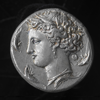

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a coin.
[RANK0:GPU0] ==> Ground truth answer: The exhibit features the Syracuse dekadrachm, a remarkable coin from antiquity renowned for its exquisite artistry and high relief, crafted by notable designers like Kimon and Euinatos. This coin has captivated enthusiasts for over 2,500 years, raising questions about how the ancient Greeks achieved such beauty using only hand tools. An interesting connection to American history is found in Theodore Roosevelt, who, while known for his political reforms, also sought to enhance American coinage. Disappointed by the mundane designs of contemporary coins, he envisioned a more artistic approach that would rival the elegance 

/workspace/my_utils.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  report_df = pd.concat([report_df, data_df], ignore_index=True)


[RANK0:GPU0] ==> [Batch: 1/8][Data: 2/10] Inference for data_id: 4, item_name: 1-decadrachm-syracuse-about-400-bce, image_name: 1-decadrachm-syracuse-about-400-bce-2.jpg:


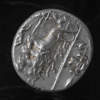

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a coin.
[RANK0:GPU0] ==> Ground truth answer: This exhibit highlights the Syracuse dekadrachm, a stunning ancient coin that exemplifies the artistry of its time, designed by renowned craftsmen such as Kimon and Euinatos. With its striking high relief, this coin has fascinated collectors for more than two millennia, prompting inquiries into the techniques used by the Greeks to achieve such intricate designs without modern tools. A significant figure connected to this coin is Theodore Roosevelt, who, while recognized for his political reform efforts, also sought to elevate the quality of American currency. Frustrated by the lackluster designs of c

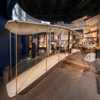

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: A full size replica of the Wright brothers first airplane is on display with photos and videos of the brothers flying in the background.
[RANK0:GPU0] ==> Ground truth answer: This exhibit showcases the remarkable 1903 Wright Flyer, the first successful powered airplane, which heralded the beginning of the aerial age. Designed by Wilbur and Orville Wright, this biplane features a 12-horsepower Wright horizontal four-cylinder engine that drives two pusher propellers through a chain-and-sprocket transmission. Notably, it employs linear skids for landing gear and is finished with natural fabric, devoid of any sealant or paint. The Wright brothers' groundbreaking achievement on

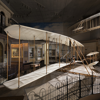

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: A collection of old fashioned planes are on display in a museum.
[RANK0:GPU0] ==> Ground truth answer: The exhibit features the iconic 1903 Wright Flyer, a pioneering aircraft that marked the dawn of powered flight. Built by the Wright brothers, Wilbur and Orville, this biplane is powered by a 12-horsepower engine that operates two pusher propellers via a sprocket-and-chain system. Its unique landing gear consists of linear skids, and it is covered in natural fabric, without any paint or sealant. The Flyer made its historic first flight on December 17, 1903, in Kitty Hawk, North Carolina, with Orville at the controls for a brief 12-second journey. The W

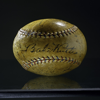

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: In this image we can see a ball on the surface.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features a remarkable autographed baseball from the legendary 1926 New York Yankees, signed by iconic players including Hall of Famers Babe Ruth and Lou Gehrig. Ruth, known for his extraordinary hitting prowess, and Gehrig, celebrated for his record of 2,130 consecutive games played, both left an indelible mark on the sport. Gehrig's battle with amyotrophic lateral sclerosis (ALS), which is often referred to as Lou Gehrig's disease, showcased his incredible humility and resilience, inspiring many during his illness. The baseball, which measures approximately 3 inches in diame

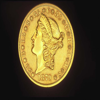

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: In this image we can see a coin with some text and numbers on it.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features a remarkable coin from the United States Mint in Philadelphia, showcasing a unique design that reflects a significant moment in American numismatic history. The obverse displays the Liberty head facing left, with the date inscribed below and details about weight and fineness surrounding it. The reverse features an eagle, similar to the standard twenty-dollar coin, but replaces the traditional motto "IN GOD WE TRUST" with "DEO EST GLORIA." This coin was part of a series inspired by the desire to enhance the competitiveness of American currency in glo

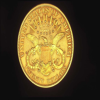

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a united states of america twenty dollars gold coin.
[RANK0:GPU0] ==> Ground truth answer: This exhibit highlights a significant gold coin minted by the United States Mint in Philadelphia, showcasing both artistic and economic significance. The coin features a Liberty head on the obverse, with the date inscribed below and weight and fineness details surrounding it. On the reverse, an eagle is depicted, but intriguingly, it bears the Latin phrase "DEO EST GLORIA" instead of the more familiar "IN GOD WE TRUST." This design was part of an initiative aimed at improving the international appeal and convertibility of American coins, paralleling the in

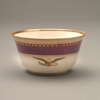

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This small cup has a purple band at the top and a design of an eagle on the front.
[RANK0:GPU0] ==> Ground truth answer: The exhibit features Abraham Lincoln's coffee cup, a poignant artifact from a pivotal moment in American history. This ceramic cup, adorned in purple with white and gold trim, was left behind by President Lincoln on a windowsill at the White House on the evening of April 14, 1865, just before he attended Ford's Theatre. A White House servant preserved this cup as a memento of that tragic night, which marked the end of Lincoln's life and the Civil War. In 1887, Captain D.W. Taylor gifted it to Robert Todd Lincoln, the president's eldest son, ensuring its 

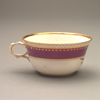

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This cup has a handle and is purple next to the gold.
[RANK0:GPU0] ==> Ground truth answer: This exhibit showcases a significant artifact: Abraham Lincoln's coffee cup, which dates back to 1887. The cup was a gift from Captain D.W. Taylor to Robert Todd Lincoln, the president's eldest son. It holds a somber history, as it was left behind by Lincoln on April 14, 1865, just before he went to Ford's Theatre for what would be his final evening. A White House servant preserved the cup, recognizing its importance as a relic of that fateful night. Crafted from ceramic and featuring a striking purple color with white and gold trim, the cup measures approximatel

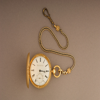

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: A watch with a gold chain is on a gray surface.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features a remarkable English gold pocket watch that belonged to Abraham Lincoln, purchased in the 1850s from Springfield jeweler George Chatterton. While Lincoln was not known for vanity, this exquisite timepiece served as a notable emblem of his achievements as a lawyer. The watch's movement, crafted in Liverpool, represents the high-quality manufacturing of the era, while the case was made by an unidentified American artisan. Notably, this watch boasts one of the finest movements available in England, capable of maintaining accurate time to within seconds daily. A hidden n

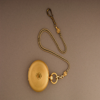

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: Gold watch with a chain that is 23 inches long.
[RANK0:GPU0] ==> Ground truth answer: This exhibit showcases Abraham Lincoln's gold pocket watch, acquired in the 1850s from a jeweler named George Chatterton in Springfield, Illinois. Although Lincoln was not typically seen as vain, the watch symbolized his professional success as a lawyer. The watch's movement was produced in Liverpool, a hub for watchmaking at the time, while the case was crafted by an unidentified American shop. Known for its exceptional quality, the watch's movement can keep time within seconds daily. A fascinating aspect of this piece is the hidden message engraved by watchmaker Jona

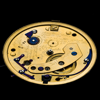

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Could you provide an overview of what is on display here?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Could you provide an overview of what is on display here?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: In this image we can see a watch.
[RANK0:GPU0] ==> Ground truth answer: This display features an exquisite gold pocket watch that once belonged to Abraham Lincoln, purchased in the 1850s from Springfield jeweler George Chatterton. While Lincoln was not known for his vanity, this watch served as a prestigious symbol of his accomplishments as a lawyer. The watch's movement was manufactured in Liverpool, a center of watch production, and it is accompanied by a high-quality case made in America. Remarkably, this timepiece has a movement capable of keeping time to within seconds each day. An intriguing story lies within, as 

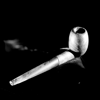

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: In this image I can see a pipe on the table.
[RANK0:GPU0] ==> Ground truth answer: The exhibit features Albert Einstein's iconic pipe, dating back to around 1948. Known for his groundbreaking contributions to theoretical physics, including the theory of relativity, Einstein is also recognized for his distinctive appearance, which prominently included this pipe. Despite reducing his smoking due to medical advice in his later years, he cherished the physical sensation of holding a pipe. This particular pipe shows signs of extensive use, with a noticeable hole worn into its bit. It was gifted to Gina Plunguian, a close friend and admirer of Einstein, before being acquired by 

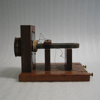

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a device that produces an electric current.
[RANK0:GPU0] ==> Ground truth answer: This exhibit at the National Museum of American History highlights the groundbreaking invention of the telephone by Alexander Graham Bell. On March 7, 1876, Bell was awarded the first patent for an apparatus designed to transmit vocal sounds telegraphically. Just three days later, he successfully communicated with his assistant, Thomas Watson, uttering the iconic words, “Mr. Watson, come here, I want to see you.” Featured in this exhibit is one of the original telephones used during a demonstration between Boston and Salem, Massachusetts, on November 26, 1876. This particular device i

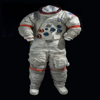

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a picture of a mannequin wearing a space suit.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features the Apollo 17 spacesuit, which was worn during the final Apollo mission that successfully landed astronauts on the moon in 1972. Launched on December 7, 1972, aboard a Saturn V rocket, Apollo 17 included Commander Eugene Cernan, command module pilot Ron Evans, and lunar module pilot Harrison Schmitt, notable for being the only geologist to have walked on lunar soil. While Evans orbited the moon, Cernan and Schmitt landed the lunar module "Challenger" in the Taurus-Littrow region, where they conducted extensive scientific activities over three days. They comple

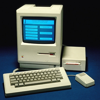

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: The computer has a blue screen with several windows on it.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features the iconic Apple "Classic" Macintosh Personal Computer, launched in 1984 by Apple Inc. This groundbreaking machine introduced a graphic user interface (GUI) to the world of personal computing, a concept that had its roots in the 1970s at Xerox's Palo Alto Research Center. Apple captured public attention with a memorable Super Bowl XVIII advertisement, marking the Macintosh's debut on January 22, 1984, with a retail price of approximately $2,500. Unlike previous computers that relied on command lines, the Macintosh allowed users to interact with programs th

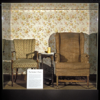

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a glass box. In this box there are two chairs. On this table there is a candle.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features an iconic upholstered wing chair that was prominently used by the character Archie Bunker, portrayed by Carroll O'Connor, in the groundbreaking television series "All in the Family." The chair, with its distinctive orange-yellow woven fabric and sturdy wooden frame, dates back to the 1940s, although its exact origins remain unclear. Initially acquired from a thrift store in Southern California, it served as a significant prop throughout the show's run from 1971 to 1979, until it was replaced by a reproduction in the final seaso

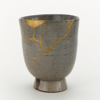

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This bowl is part of the collection of the Asian Art Museum of San Francisco. It is made of ceramic and is grey in color.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features a remarkable 17th-century tea bowl from the Satsuma ware collection, specifically the White Satsuma type, hailing from Kagoshima prefecture in Japan during the Edo period. The bowl, made of stoneware and finished with a clear, crackled glaze, has a storied past, having been broken and subsequently repaired using the traditional Japanese art of kintsugi, or golden joinery. This technique not only mends the bowl but also accentuates its history by highlighting the cracks with lacquer infused with

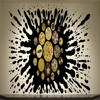

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a painting.
[RANK0:GPU0] ==> Ground truth answer: This exhibition features the captivating work of Yinka Shonibare, a prominent artist born in London in 1962. The display showcases 25 circular canvases of varying sizes, meticulously arranged over a large-scale ink splatter pattern that has been applied using a template. Each canvas is adorned with intricate foliate designs painted in black and gold, utilizing Dutch wax printed fabrics. Shonibare's earlier works are characterized by small square canvases in a grid layout, while his more recent pieces, including this one, challenge traditional boundaries with their dynamic black splatter forms. The artwork draws insp

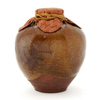

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a brown vase with a brown and red design on it.
[RANK0:GPU0] ==> Ground truth answer: The exhibit titled "Chigusa and the Art of Tea," located at the Arthur M. Sackler Gallery, delves into the intricate relationship between Japanese tea culture and the art of collecting. It highlights how collectors engaged with tea-leaf storage jars through the traditional tea ceremony, known as chanoyu, by bestowing names and adorning these jars with exquisite textiles. Central to this theme is the jar named Chigusa, which evolved from a simple Chinese import into a revered object of beauty and contemplation, while still retaining its functional purpose. Notably, 16th-century tea

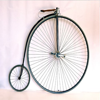

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: A penny farthing bicycle is on display.
[RANK0:GPU0] ==> Ground truth answer: This exhibit at the National Museum of American History celebrates the arrival of spring with a spotlight on an original 1886 Columbia Light Roadster high-wheel bicycle. This remarkable artifact, which originally sold for around $135, was produced by the Pope Manufacturing Co., recognized as the first bicycle manufacturer in the United States. The bicycle features a distinctive configuration with a 53-inch front wheel, supported by 60 spokes, and an 18-inch rear wheel with 20 spokes, available in a range of sizes for riders. Accompanying this bicycle is a historic photograph showcasing one of Ame

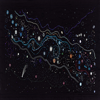

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a painting. In this painting, we can see some objects.
[RANK0:GPU0] ==> Ground truth answer: The exhibit titled “Milky Way, Starry Night # 2” features the work of Gwich'in artist Margaret Nazon, who hails from Tsiigehtchic in the Northwest Territories of Canada. Created in 2021, this piece reflects Nazon's lifelong fascination with the stars, a passion that she fully embraced in her art later in life after being inspired by Hubble Space Telescope imagery. Nazon's work is distinctive as it incorporates swirling galaxies, a departure from traditional Gwich'in beadwork, showcasing her unique artistic style. This artwork is part of the “Lights Out: Recovering Our Night

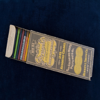

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a picture of a box which contains crayons.
[RANK0:GPU0] ==> Ground truth answer: This exhibit at the Smithsonian's National Museum of American History highlights a pack of Crayola Crayons from 1903, celebrating a beloved back-to-school tradition. Invented by cousins Edwin Binney and C. Harold Smith, the crayons were crafted using paraffin wax and nontoxic pigments, making them safe and durable for young artists. The name "Crayola," created by Alice Binney, combines the French word for chalk, "craie," with "oleaginous," referring to its waxy texture. This particular set, aimed at budding artists, features 28 vibrant colors, including celestial blue and rose pink, an

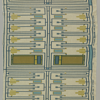

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a poster. In this poster we can see some text and some designs.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features a striking piece designed by the renowned American architect Frank Lloyd Wright, who lived from 1867 to 1959. The textile, produced by F. Schumacher & Co., a New York-based manufacturer established in 1889, showcases a captivating geometric pattern composed of rectangular blocks in shades of light blue and various olive tones, intricately connected by fine lines of darker blue against an off-white backdrop. The length of the printed linen measures 120 by 57.5 cm (47 1/4 by 22 5/8 inches), with a repeat height of 63.5 cm (25 inches). Additional

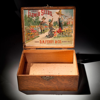

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a wooden box with a painting on it.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features an antique seed box from the late 19th century, specifically from the renowned D.M. Ferry & Co., and is part of the Smithsonian's celebration of National Garden Month. In the 1800s, seed packets were commonly stored in decorative wooden boxes that showcased vibrant labels from seed companies, serving as effective marketing tools on general store counters. This particular seed box, which showcases the D.M. Ferry & Co. label, is significant for its association with the invention of the “commission box,” a display rack that revolutionized retail presentation. Acquired by th

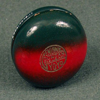

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: A red and black item is marked with the words Gunning YoYo.
[RANK0:GPU0] ==> Ground truth answer: This exhibit at the Smithsonian's National Museum of American History highlights the captivating story of the yo-yo, a toy that gained immense popularity in America thanks to Chicago businessman Donald F. Duncan Sr. In 1928, Duncan discovered the yo-yo during a business trip to San Francisco, where it was being sold by Pedro Flores, a Filipino immigrant. Flores had begun manufacturing the toy, which he named “yo-yo,” meaning “come-come” in Tagalog. By early 1929, he had established his own company and produced over 100,000 wooden yo-yos, recognizing the need for demonstrations

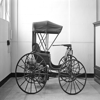

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a black and white image. In this image we can see a vehicle on the floor. In the background we can see a wall and a window.
[RANK0:GPU0] ==> Ground truth answer: The exhibit features the 1893-94 Duryea automobile, recognized as one of the earliest American-made vehicles. On September 21, 1893, Frank Duryea conducted a road test of this innovative automobile, which was essentially a second-hand carriage outfitted with a gasoline engine, in Springfield, Massachusetts. In 1896, Frank and his brother Charles, along with financial partners, established the Duryea Motor Wagon Company, marking it as the first American enterprise to manufacture and sell automobiles. This p

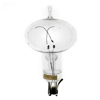

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a bulb.
[RANK0:GPU0] ==> Ground truth answer: This exhibit showcases the Edison Light Bulb, which dates back to 1879 and represents a pivotal moment in the history of innovation. Thomas Edison utilized this carbon-filament bulb during the inaugural public demonstration of his groundbreaking invention—the light bulb, recognized as the first viable electric incandescent lamp. The mechanism of the bulb involves an electrical current flowing through a metal filament wire, which heats up to an intense temperature, ultimately producing light. To safeguard the hot filament from oxygen, the bulb is encased in glass filled with inert gas. This significant demonstration took

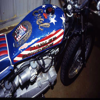

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: A harley davidson motorcycle with an american flag paint job.
[RANK0:GPU0] ==> Ground truth answer: This exhibit at the Smithsonian's National Museum of American History showcases Evel Knievel's iconic 1972 Harley-Davidson XR-750, a motorcycle synonymous with the legendary daredevil's thrilling performances. Evel Knievel, born Robert Craig Knievel, captivated audiences with his death-defying stunts, which often resulted in numerous injuries, including 35 to 40 broken bones throughout his career. His televised daredevil shows, beginning in 1965, featured spectacular jumps over rows of vehicles, including cars, trucks, and buses. The XR-750, constructed from steel, aluminum,

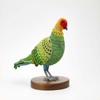

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a toy of a bird.
[RANK0:GPU0] ==> Ground truth answer: The exhibit features Laurel Roth Hope's intriguing work titled “Biodiversity Reclamation Suit: Carolina Parakeet,” created in 2009 and displayed at the Smithsonian American Art Museum. This piece cleverly employs humor to highlight the grave issue of species extinction. Through her “Biodiversity Reclamation Suits,” Hope enables common rock pigeons to don the guise of extinct North American birds, symbolically addressing the loss of biodiversity. Utilizing traditional crafting techniques such as carving, embroidery, crochet, and collage, she transforms everyday materials into striking animal sculptures that evok

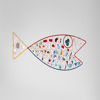

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a painting of a fish.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features "Fish," a captivating work by renowned artist Alexander Calder, created in 1945 and housed at the Hirshhorn Museum and Sculpture Garden in Washington, D.C. Calder, who was born into a family of artists and initially trained as a mechanical engineer, transitioned to art after working as a freelance illustrator. His journey took him to Paris, where he became inspired by avant-garde movements and began crafting his signature wire sculptures, often referred to as “drawings in space.” Influenced by the minimalist aesthetic of Piet Mondrian, Calder pioneered the concept of “mobiles” in 1931

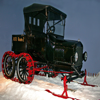

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a black color vehicle on the snow.
[RANK0:GPU0] ==> Ground truth answer: This exhibit at the Smithsonian's National Postal Museum showcases a 1921 Ford Model T equipped with a unique snow attachment, highlighting the ingenuity of early 20th-century rural mail carriers. As these carriers transitioned from horse-drawn sleds to automobiles, they faced challenges navigating deep snow. In response, Virgil White innovated by converting cars into snowmobiles, replacing front tires with skis and rear tires with caterpillar treads. His invention, dubbed the Snowbird, provided a cost-effective solution for winter deliveries, eliminating the need for horses. Initially, White'

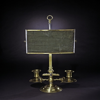

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: In this image I can see a stand and on it I can see two candles. I can also see this image is little bit in dark.
[RANK0:GPU0] ==> Ground truth answer: This exhibit showcases a significant artifact linked to George Washington, specifically a brass candle stand believed to have been used by him while composing his Farewell Address in 1796. After serving two terms as president, Washington chose to retire to Mount Vernon, where he penned his final thoughts for the nation, urging unity among Americans amidst emerging political factions. His Farewell Address was first published in The American Daily Advertiser and has since been commemorated annually by the United States Senate

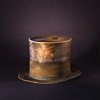

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a hat.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features President Abraham Lincoln's iconic top hat, housed at the Smithsonian's National Museum of American History. Acquired from Washington hat maker J.Y. Davis, this hat stands as a symbol of Lincoln's stature, both physically at 6'4” and in his leadership. Notably, a black silk mourning band adorns the hat, honoring the memory of his son Willie, who passed away in 1862. While the exact date of acquisition remains unknown, the hat was last worn by Lincoln on the fateful night of April 14, 1865, as he headed to Ford's Theatre. Following Lincoln's assassination, the War Department safeguarded the hat along

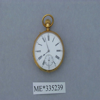

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: A pocket watch with roman numerals is displayed above a label that says ME*335239.
[RANK0:GPU0] ==> Ground truth answer: This exhibit at the Smithsonian's National Museum of American History features a remarkable timepiece belonging to Helen Keller, who was born on June 27, 1880. Keller, a pivotal figure in advocating for women's suffrage and workers' rights, faced significant challenges after losing her sight and hearing due to illness at a young age. Her breakthrough came with the help of Anne Sullivan, who taught her to communicate. The Swiss-made "touch watch," gifted to Keller by John Hitz in 1892, is designed with pins around its edge to indicate the hours, allowing 

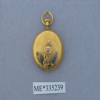

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: A gold pocket watch is on display above a label that says ME*335239.
[RANK0:GPU0] ==> Ground truth answer: This exhibit showcases an extraordinary pocket watch that once belonged to Helen Keller, who was born on June 27, 1880. Keller, known for her advocacy for women's rights and disability rights, faced immense challenges after becoming deaf and blind at a young age. Her life changed dramatically when she met Anne Sullivan, who taught her to communicate. The watch, presented to Keller by John Hitz in 1892, features a unique design with pins around the case that allow the wearer to feel the time, making it particularly suitable for someone who could not

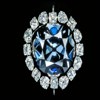

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a diamond pendant.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features a stunning diamond necklace crafted by Cartier, Inc., showcasing a primary gem that weighs an impressive 45.52 carats. The diamond, characterized by its dark gray-blue hue, is cut in a modified antique cushion style, which enhances its unique visual appeal. Originating from India, this exquisite piece is part of the Mineral Sciences collection, specifically within the Gems category at the National Museum of Natural History. The necklace is cataloged under the USNM number NMNH G3551-00 and is a singular specimen in this exhibit, last modified on September 26, 2022. For more detailed infor

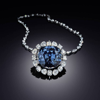

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This necklace contains the largest blue diamond in the world.
[RANK0:GPU0] ==> Ground truth answer: This exhibit showcases a remarkable diamond necklace by Cartier, Inc., featuring a single primary gem that weighs 45.52 carats. The diamond is distinguished by its dark gray-blue color and is elegantly cut in a modified antique cushion shape, which adds to its vintage charm. Sourced from India, this necklace is a highlight of the Mineral Sciences collection at the National Museum of Natural History, categorized under Gems. The record for this exquisite piece is identified as NMNH G3551-00 and was last updated on September 26, 2022. For further details, yo

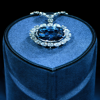

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Could you provide an overview of what is on display here?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Could you provide an overview of what is on display here?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: In this image we can see a necklace on the blue color cloth.
[RANK0:GPU0] ==> Ground truth answer: On display is a captivating diamond necklace by Cartier, Inc., featuring a single, striking primary gem that weighs 45.52 carats. This diamond exhibits a dark gray-blue coloration and is expertly cut in a modified antique cushion style, making it a true work of art. The necklace hails from India and is part of the Mineral Sciences department's Gems collection at the National Museum of Natural History. It is cataloged under the USNM number NMNH G3551-00, with the last modification recorded on September 26, 2022. For more in

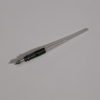

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a pen.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features an Esterbrook pen that holds significant historical importance as it was used by President Lyndon B. Johnson to sign the Civil Rights Act of 1964 on July 2 of that year. Part of the Smithsonian's National Museum of African American History and Culture collection, this particular pen was among over 70 identical pens distributed to key figures in the Civil Rights Movement. The journey to the enactment of this landmark legislation was fraught with challenges, initially introduced by President John F. Kennedy before his tragic assassination in November 1963. The bill's fate then rested with President Jo

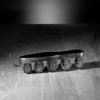

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: In this image we can see a toy on the surface.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features the Volito, an innovative inline skate crafted in 1823 by Robert John Tyers. As athletes prepare for the 2014 Winter Olympics, it's intriguing to consider how skaters of the 19th century maintained their skills without the luxury of indoor rinks. The Volito is distinguished by its wooden sole, a single row of five wooden wheels, and a unique curved iron bar at the front, which functioned as a basic brake. What truly set this skate apart was its unequal wheel sizes—larger in the center and smaller at the ends—allowing skaters to navigate turns with greater ease. This r

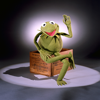

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a toy of a frog.
[RANK0:GPU0] ==> Ground truth answer: This exhibit showcases Kermit the Frog, a beloved character created by Jim Henson, who has become an iconic figure in children's television. Kermit, a vibrant green puppet, first appeared in 1955 on the show "Sam and Friends" and has since been the star of "The Muppet Show" and a regular on "Sesame Street." Known for his calm demeanor amidst chaos, Kermit is famous for his poignant song “Bein' Green,” which reflects on the challenges of his color while ultimately celebrating his identity. The puppet is crafted from various materials, including synthetic fiber, felt, and plastic, and measures approximately 27 in

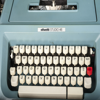

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: A blue, Olivetti Studio 46, typewriter with a single red key.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features the typewriter of Octavia Estelle Butler (1947–2006), a celebrated author in the realm of science fiction. Butler is renowned for her impactful works, including the five-volume Patternist series, the Xenogenesis trilogy—also known as Lilith's Brood—and the thought-provoking novels Parable of the Sower and Parable of the Talents, along with her acclaimed short story collection, Bloodchild and Other Stories. Her writing uniquely blended elements of African American history with speculative futures and alien psychology, establishing a g

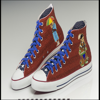

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: These are the shoes which are in red color.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features a remarkable piece titled "Kiowa Ah-Day," created by Kiowa artist Teri Greeves in 2004. The artwork, which takes the form of sneakers, is a unique blend of traditional and contemporary materials, incorporating cotton canvas, glass beads, and commercial rubber. Measuring 33 x 11 x 15 cm, this piece exemplifies Greeves' innovative approach, showcasing overlay beadwork that reflects the rich cultural heritage of the Kiowa people. Acquired by the National Museum of the American Indian from Thirteen Moons Gallery in Santa Fe, New Mexico, this work is part of a broader collect

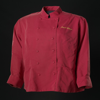

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a red color jacket.
[RANK0:GPU0] ==> Ground truth answer: This exhibit showcases a significant collection from the Smithsonian's National Museum of African American History and Culture, featuring a gift from Dooky Chase's Restaurant and renowned Chef Leah Chase. Celebrated for her assertion that “we changed the world over a bowl of gumbo,” Chase played a pivotal role in the civil rights movement by hosting strategy meetings at her restaurant. Known as "The Queen of Creole Cuisine," she elevated New Orleans Creole cooking to global prominence. Alongside her husband, jazz musician Edgar “Dooky” Chase II, she transformed a modest sandwich shop established by her mothe

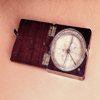

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a compass.
[RANK0:GPU0] ==> Ground truth answer: This exhibit showcases a remarkable silver-plated pocket compass that dates back to around 1804, purchased by Meriwether Lewis in preparation for the historic Lewis and Clark Expedition. Crafted by Philadelphia instrument maker Thomas Whitney, the compass features a mahogany box, a brass rim graduated in degrees, a paper dial, and two brass sight vanes, all housed in a leather carrying case. While it remains uncertain whether Lewis intended the compass for himself or as a gift for his expedition partner, William Clark, it served as a vital navigational tool during their journey. Under President Thomas Jefferson's dir

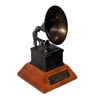

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a trophy.
[RANK0:GPU0] ==> Ground truth answer: This exhibit showcases Bob Newhart's 1960 Grammy Award, a significant artifact from the celebrated comedian's illustrious career. Born on September 5, 1929, in Oak Park, Illinois, Newhart has entertained audiences for over sixty years with his signature deadpan style, cleverly critiquing social norms and the absurdities of American life. His groundbreaking comedy album, The Button-Down Mind of Bob Newhart, made history by becoming the first comedy LP to reach No. 1 on the Billboard charts and won him a Grammy for Album of the Year, making him the only comedian to win a Grammy for Best New Artist. Newhart's influence e

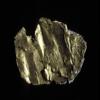

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a gold leaf.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features a remarkable gold nugget from 1848, housed at the Smithsonian's National Museum of American History. Regarded as the first gold piece discovered at Sutter's Mill in California, this nugget played a pivotal role in sparking the infamous gold rush. On January 24, 1848, while overseeing the construction of a sawmill, James Marshall noticed a glimmer in the water and retrieved what he identified as a thin scale of pure gold. Following this discovery, Marshall presented the scale to Capt. Joseph L. Folsom, who documented it as the first gold found in Northern California. By August of that year, thi

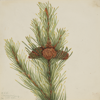

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a painting. In this painting, we can see a plant with some fruits.
[RANK0:GPU0] ==> Ground truth answer: This exhibit showcases the exquisite watercolor work of Mary Vaux Walcott, particularly her piece titled "Lodgepole Pine (Pinus Contorta murrayana)" created in 1921. Measuring 10 x 7 inches, this artwork is part of the Smithsonian American Art Museum's collection, gifted by the artist in 1970. Walcott's journey into botanical illustration began when a botanist encouraged her to paint a rare blooming arnica. Her marriage to Charles Doolittle Walcott, the Smithsonian's Secretary, in 1914 led to summers spent in the Canadian Rockies, where she produced hundreds of 

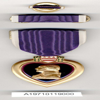

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: A Purple Heart is shown with a bronze star and a blue ribbon.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features the esteemed United States Purple Heart, a distinguished military decoration awarded to those wounded or killed while serving in the U.S. armed forces. The medal is crafted in a striking gold heart shape, showcasing a profile relief of George Washington at its center, set against a rich purple enamel background. Above Washington's bust, the medal is adorned with a shield displaying his family coat of arms. The reverse side bears the embossed inscription "FOR MILITARY MERIT," highlighting the medal's significance. It is suspended from a silk purple ribbo

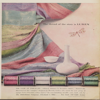

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: In this image we can see a poster. On the poster there is a cloth. Also there is a vase. And there are threads. Also there is some text.
[RANK0:GPU0] ==> Ground truth answer: This exhibit, titled "The Thread of the Story Is Lurex: The Look of Porcelain," showcases the work of renowned American textile designer Dorothy Liebes, who significantly influenced various design disciplines from the 1930s to the 1960s. Known for her vibrant colors and rich textures, Liebes developed a distinctive style that became synonymous with the modern American aesthetic, referred to as the “Liebes Look.” Her collaborations with notable architects and designers, such as Frank Lloyd Wright and R

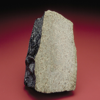

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a large rock that is textured and colored unevenly.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features a fragment of the Nakhla meteorite, which is significant as one of the thirty-four meteorites believed to have originated from Mars. The Nakhla meteorite fell to Earth on June 28, 1911, around 9 a.m. in Alexandria, Egypt, where it was observed exploding in the atmosphere before landing in approximately 40 pieces, weighing a total of 22 pounds. These fragments were found buried up to a meter deep in the ground. The Smithsonian acquired two samples shortly after the fall, and in 1962, it added a 480-gram piece to its collection, totaling 650 grams of Nakhla

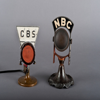

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: Two old fashioned microphones with one saying CBS and one saying NBC.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features a significant artifact from the era of President Franklin D. Roosevelt's "Fireside Chats," a series of informal radio addresses he delivered to the American public starting on March 12, 1933. With the nation grappling with the Great Depression, Roosevelt's ability to communicate directly with citizens through radio became a vital tool for shaping public opinion and providing reassurance. The exhibit highlights an RCA Type 50-A microphone, adorned with the National Broadcasting Company logos, which was used during these broadcasts. Acquired by th

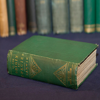

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: A green book with gold lettering sits in front of many other books.
[RANK0:GPU0] ==> Ground truth answer: This exhibit showcases "On the Origin of Species" by Charles Darwin, published in 1859, and is part of the Smithsonian Institution Libraries collection. It commemorates the May 11, 1820, anniversary of the HMS Beagle's launch, the vessel that carried Darwin on his pivotal scientific journey. The Beagle was launched from the Woolwich Dockyard in London and underwent several adaptations before embarking on its second survey voyage on December 27, 1831. Darwin, a young naturalist, joined the crew to provide geological insights, and his extensive research during the five-y

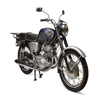

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a picture of a motor bike.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features Robert M. Pirsig's iconic 1966 Honda Super Hawk motorcycle, prominently showcased at the Smithsonian's National Museum of American History. This motorcycle is not just a vehicle; it is a symbol of the philosophical journey outlined in Pirsig's influential book, "Zen and the Art of Motorcycle Maintenance: An Inquiry Into Values." Published in 1974, the book quickly became a bestseller, selling over a million copies within its first year and igniting a cultural movement that encouraged individuals to reevaluate their relationship with technology and seek a harmonious existence. The

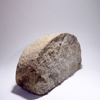

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a rock.
[RANK0:GPU0] ==> Ground truth answer: The exhibit features the Plymouth Rock Piece, a significant artifact housed at the National Museum of American History, which is believed to be linked to the landing of the Mayflower Pilgrims in 1620. According to tradition, this rock marks the site where William Bradford and his fellow settlers first arrived in Plymouth, Massachusetts. Bradford, who played a pivotal role as a leader and governor of the Plymouth Colony, is also credited with the establishment of Thanksgiving as it is celebrated in the United States today. The rock has a storied past, having been relocated in 1774 from its original position to the town s

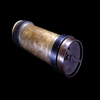

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: In this image we can see a cylindrical object.
[RANK0:GPU0] ==> Ground truth answer: This exhibit at the Smithsonian's National Postal Museum showcases a Pneumatic Mail Container from 1953, a fascinating relic of a bygone era when cities utilized pneumatic tube systems for mail delivery. Originating in the late 1890s, these systems were ingeniously designed to transport mail through underground tubes, with each canister capable of holding up to 500 letters. The canisters, or carriers, were propelled by compressed air, allowing them to travel at speeds averaging 35 miles per hour. At the height of their operation, these systems facilitated the movement of an astounding 6 mi

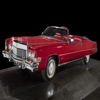

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: In this image I can see a red colour car on the black colour surface.
[RANK0:GPU0] ==> Ground truth answer: The "Rock 'n' Roll Ride" exhibit at the Smithsonian's National Museum of African American History and Culture showcases a remarkable piece of musical history: Chuck Berry's striking red 1973 Cadillac Eldorado. This vehicle is prominently featured in the museum's "Musical Crossroads" exhibition. The Cadillac was a cherished part of Berry's personal collection and gained fame during the filming of the 1987 documentary "Hail! Hail! Rock 'n' Roll," directed by Taylor Hackford. The film captures the essence of two concerts held in 1986 to honor Berry's 60th birthday, and 

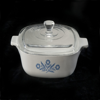

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: White pot with a blue flower design by pyrex.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features a quintessential kitchen item often associated with holiday gatherings—a white casserole dish made by CorningWare in 1965. Adorned with the iconic blue cornflower motif, this dish represents a blend of innovation and tradition. Originally created for military use during World War II, CorningWare's Pyroceram material later emerged as an ideal choice for bakeware, thanks to its ability to endure rapid temperature shifts and resist stains and odors. Its versatility allowed it to transition seamlessly from cooking to freezing to serving, making it a bel

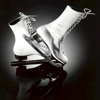

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: In this image we can see a pair of skates on the surface.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features the autographed ice skates of Sonja Henie, a pioneering figure in women's figure skating, dating back to around 1945. Henie, a Norwegian skater, revolutionized the sport in the late 1920s and 1930s by introducing white leather skates, a significant departure from the traditional black skates. Her enchanting performances earned her the first of ten consecutive world titles in 1927, where she captivated audiences with her innovative dance style. Henie's influence extended beyond the rink; she was the first to blend choreography with figure skating and popular

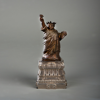

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a statue of liberty.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features one of the earliest models of the Statue of Liberty, often referred to as the American Committee Model. Crafted in the United States, this statuette was produced in large quantities, with tens of thousands sold to raise funds for the construction of the statue's pedestal in New York Harbor. The design, created by French sculptor Frédéric-Auguste Bartholdi, was made available in both six-inch and twelve-inch sizes, with a national newspaper campaign promoting them at one dollar and five dollars respectively. Richard Butler, a rubber manufacturer from New York, led the American Committee

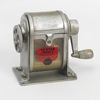

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: In this image we can see a machine.
[RANK0:GPU0] ==> Ground truth answer: The exhibit features the Dexter Model 3 Pencil Sharpener, crafted around 1920 by the Automatic Pencil Sharpener Company (APSCO) in Rockford, Illinois. This charming artifact, made from metal, cellulose, and painted wood, measures 10.8 x 12.7 x 7 cm (4 1/4 in. x 5 in. x 2 3/4 in.). A gift from Lucy Commoner, it holds a significant place in the Cooper Hewitt, Smithsonian Design Museum collection, although it is not currently on display. As the back-to-school season approaches, this sharpener evokes nostalgia for many, reminiscent of countless school days. The Dexter Model 3 was an evolution of earlier 

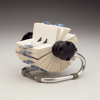

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: A round item with cards on it including one that says CARD FILE.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features the iconic Rolodex Open Rotary Card File, a quintessential office supply that revolutionized the way people organized their business contacts before the advent of digital technology. Manufactured by the Rolodex Corporation in the USA, this particular model is crafted from bent tubular metal, molded plastic, rubber, and paper, measuring 18 x 18 x 16.5 cm. The Rolodex operates on a cylindrical design, allowing users to easily flip through A-Z index cards to find contact information. Despite the rise of smartphones and computers, the

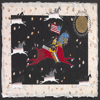

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: In this image we can see a painting.
[RANK0:GPU0] ==> Ground truth answer: The exhibit features the "Lakota Horse Mask," created in 2008 by Jim Yellowhawk, a member of the Cheyenne River Lakota tribe. This striking piece, which utilizes acrylic on paper and gold leaf, symbolizes the profound relationship between American Indians and horses, which many tribes refer to as the Horse Nation. Horses were not only allies in times of peace but also played a vital role during conflicts, deeply influencing the cultural landscape of various tribes. Interestingly, horses first emerged in the Americas over 40 million years ago, later becoming extinct before being reintroduced by Colum

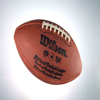

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: In this image I can see a football in the air.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features the iconic Wilson Duke football, which has been the official ball of the Super Bowl since Super Bowl II in 1968. The football on display was specifically used during Super Bowl XIV, held at the Rose Bowl in Pasadena, California, on January 20, 1980. In this thrilling game, the Pittsburgh Steelers triumphed over the Los Angeles Rams with a score of 31-19, marking the Steelers' fourth Super Bowl victory. Notably, it was also the second consecutive year that quarterback Terry Bradshaw earned the Most Valuable Player award. The Wilson Duke football, known for its premium 

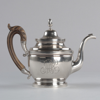

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a silver teapot with a monogram of AH engraved on it.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features a remarkable silver teapot created by American artisan Peter Bentzon, dating from approximately 1817 to 1829. The teapot showcases an elegant oval vase shape, supported by a spreading pedestal foot. Its design includes a gracefully curved spout, which is topped with an incised patera, and a scroll handle adorned with wooden leaf caps. The hinged domed lid is finished with an acorn finial, adding to its aesthetic appeal. Notably, the piece bears the scripted monogram "MC" engraved on its side, alongside the name "Rebecca Dawson" inscribed along the botto

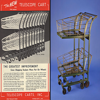

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a poster. On the left side there is a trolley. On the right side there is a poster.
[RANK0:GPU0] ==> Ground truth answer: The exhibit at the National Museum of American History features the innovative Telescoping Shopping Cart, designed by Orla E. Watson in 1946. This clever invention, first introduced in 1947 at Floyd's Super Market in Kansas City, Missouri, revolutionized the way consumers shop by allowing carts to nest together for efficient storage. Watson asserted that these new carts utilized only one-fifth of the space of traditional carts when parked, making them a practical solution for busy shoppers. This display is part of the Smithsonian's inaugural maj

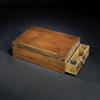

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a wooden box with two drawers.
[RANK0:GPU0] ==> Ground truth answer: This exhibit showcases the portable writing desk designed by Thomas Jefferson, which he used to draft the Declaration of Independence in 1776. The desk features a hinged writing board and a locking drawer for storing essential writing materials such as papers, pens, and an inkwell. During the summer of 1776, as members of the Second Continental Congress prepared to declare independence from Great Britain, Jefferson, a Virginia delegate, was tasked with drafting this pivotal document. He later noted that the declaration was meant to reflect the collective American sentiment rather than being an ori

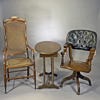

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: There are three chairs. The chair on the left has a high back and is padded. The chair in the middle has a round table. The chair on the right has a high back and a round table.
[RANK0:GPU0] ==> Ground truth answer: This exhibit focuses on a pivotal moment in American history, specifically the surrender of the Confederate Army at Appomattox Court House on April 9, 1865. It showcases the chair used by General Ulysses S. Grant during his negotiations with General Robert E. Lee, marking the effective conclusion of the Civil War. The exhibit highlights how Grant, seated in this chair, drafted and signed the surrender terms, a significant act that symbolized the end of hostilit

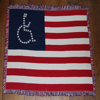

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: On the floor is a blanket with the American flag on it.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features a unique lap blanket that has been hand-altered to incorporate the universal access symbol, represented by stitched stars, reflecting the ideals of freedom and independence associated with the American flag. Created by advocates from the American Disabled for Attendant Programs Today (ADAPT), this piece signifies the ongoing struggle for civil rights among individuals with disabilities. Founded in 1983 in Denver, ADAPT emerged from the disability rights movement, which gained momentum after World War II as individuals with disabilities formed communities and 

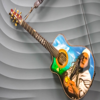

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: A guitar is against a wall with the word Vive painted on it.
[RANK0:GPU0] ==> Ground truth answer: This exhibit showcases the guitar of Carlos Vives, a renowned Colombian singer and Grammy Award winner celebrated for his contributions to the vallenato music genre. Vallenato, originating from Colombia's Atlantic coast, blends European instruments like the accordion with rich, poetic lyrics and the traditional rhythms of the Arhuaco indigenous people. Historically, vallenato was performed by rural workers and cowboys, remaining largely within local communities until its revitalization in the 1990s by artists like Vives, who infused it with pop and rock elements. This transfo

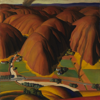

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a painting. In this image we can see hills, trees, houses, road, grass and sky.
[RANK0:GPU0] ==> Ground truth answer: This exhibition features a captivating painting by Ross Dickinson, a talented artist who thrived during the Great Depression. Created while he was part of the Public Works of Art Project, the artwork vividly portrays California's Central Valley, showcasing lush green fields alongside a small river, all framed by stark, arid hills. The scene evokes the promised land sought by many families fleeing the Dust Bowl, yet Dickinson introduces an unsettling element—a small controlled fire in the foreground and a larger plume of smoke rising from the distant

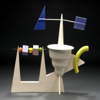

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: This is a sculpture.
[RANK0:GPU0] ==> Ground truth answer: This exhibit features the imaginative work of artist Peter Shire, born in Los Angeles in 1947. Notably, Shire's teapots, particularly the Weathervane Teapot, are vibrant constructions made from clay slabs, showcasing a playful arrangement of three-dimensional squares, balls, squiggly rods, and hollow tubes. Shire aimed to challenge conventional notions of "tea-time," making it an experience that is inclusive and accessible to everyone. The design of this teapot invites interaction, prompting viewers to ponder how to hold it for pouring, or whether it is even functional as a teapot. After 1985, Shire shifted his foc

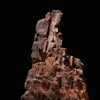

[RANK0:GPU0] ==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
[RANK0:GPU0] ==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
[RANK0:GPU0] ==> Model generated answer: In this image we can see a wooden object.
[RANK0:GPU0] ==> Ground truth answer: The exhibit features the Spotsylvania tree stump, a poignant relic from the Civil War, dating back to 1864–65, located at the Smithsonian's National Museum of American History. This tree, once a majestic oak, stood in a serene meadow near Spotsylvania Court House, Virginia, until May 12, 1864, when it became a silent witness to the brutal conflict between Confederate forces and the Union's Second Corps. The area, now known as the Bloody Angle, transformed dramatically over the course of a single day, as the fierce combat led to approximately 31,000 casualties. The tree stump bears the scars of 

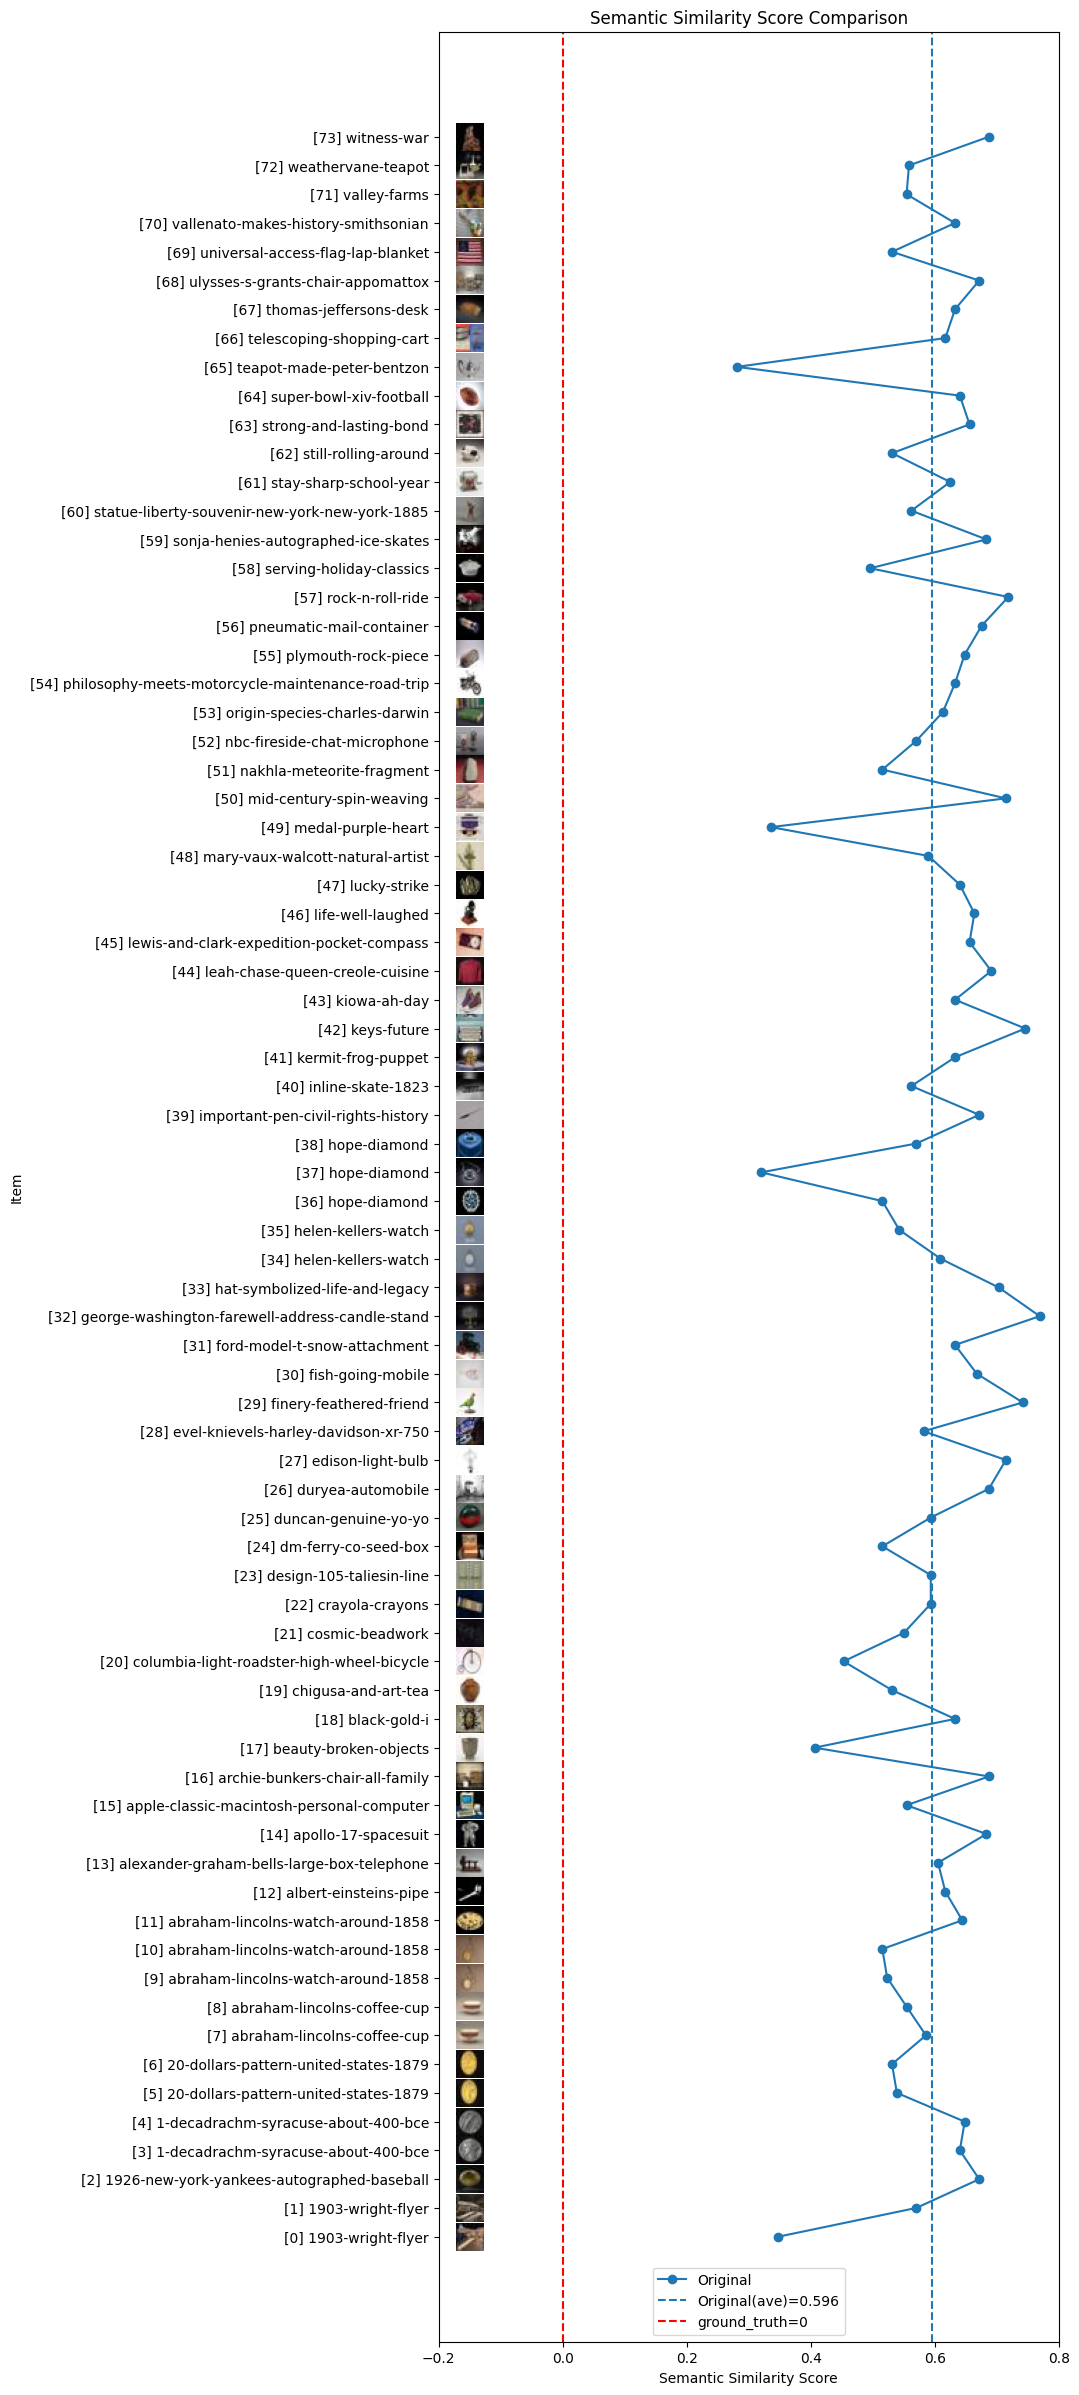

[RANK0:GPU0] ==> Setting up pad token (<pad>) in processor...
[RANK3:GPU3] ==> Setting up pad token (<pad>) in processor...[RANK2:GPU2] ==> Setting up pad token (<pad>) in processor...[RANK1:GPU1] ==> Setting up pad token (<pad>) in processor...


[RANK0:GPU0] ==> [Original] Regular token count: 32000, regular + special token count: 32003, pad token in tokenizer: <unk>
[RANK3:GPU3] ==> [Original] Regular token count: 32000, regular + special token count: 32003, pad token in tokenizer: <unk>[RANK2:GPU2] ==> [Original] Regular token count: 32000, regular + special token count: 32003, pad token in tokenizer: <unk>

[RANK1:GPU1] ==> [Original] Regular token count: 32000, regular + special token count: 32003, pad token in tokenizer: <unk>
[RANK0:GPU0] ==> Adding new pad token: <pad>
[RANK2:GPU2] ==> Adding new pad token: <pad>[RANK3:GPU3] ==> Adding new pad token: <pad>

[RANK0:GPU0] ==> [Updated] Regular token count: 32000, regular + special token count: 32004, pad token in tokenizer: <pad

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`



[RANK1:GPU1] ==> Checking if resizing of model embeddings is needed...


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
The new lm_head weights will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `

[RANK3:GPU3] ==> Resized model embeddings from 32003 to 32004.
[RANK3:GPU3] ==> Selecting Layers for Full Fine-Tuning...
[RANK2:GPU2] ==> Resized model embeddings from 32003 to 32004.
[RANK2:GPU2] ==> Selecting Layers for Full Fine-Tuning...
[RANK1:GPU1] ==> Resized model embeddings from 32003 to 32004.
[RANK1:GPU1] ==> Selecting Layers for Full Fine-Tuning...


The new lm_head weights will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


[RANK0:GPU0] ==> Resized model embeddings from 32003 to 32004.
[RANK0:GPU0] ==> Selecting Layers for Full Fine-Tuning...
[RANK0:GPU0] ==> Printing model info...
[RANK0:GPU0] ==> Model type: Idefics2ForConditionalGeneration
[RANK0:GPU0] ==> Model is located on device: cuda:0
[RANK0:GPU0] ==> Model device map: All layers are on CPU
[RANK0:GPU0] ==> For complete model info (type, architecture, config, generation config, device map), refer to ./results/model_info/full_finetuning_model_info.txt.
[RANK0:GPU0] ==> Printing model parameters...
[RANK0:GPU0] model.vision_model.embeddings.patch_embedding.weight (677376, torch.bfloat16, cuda, False)
[RANK0:GPU0] model.vision_model.embeddings.patch_embedding.bias (1152, torch.bfloat16, cuda, False)
[RANK0:GPU0] model.vision_model.embeddings.position_embedding.weight (5644800, torch.bfloat16, cuda, False)
[RANK0:GPU0] model.vision_model.encoder.layers.0.self_attn.k_proj.weight (1327104, torch.bfloat16, cuda, False)
[RANK0:GPU0] model.vision_model.en

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Using auto half precision backend


[RANK0:GPU0] ==> Printing trainer info...
[RANK0:GPU0] ==> trainer.model is located on device: cuda:0
[RANK0:GPU0] ==> trainer.accelerator.distributed_type: DistributedType.FSDP
[RANK0:GPU0] ==> trainer.accelerator.state.num_processes: 4
[RANK0:GPU0] ==> trainer.accelerator.state.process_index: 0
[RANK0:GPU0] ==> trainer.accelerator.state.local_process_index: 0
[RANK0:GPU0] ==> trainer.accelerator.state.device: cuda:0
[RANK0:GPU0] ==> trainer.accelerator.state.mixed_precision: bf16
[RANK0:GPU0] ==> trainer.accelerator.state.fsdp_plugin: {'sharding_strategy': <ShardingStrategy.FULL_SHARD: 1>, 'backward_prefetch': <BackwardPrefetch.BACKWARD_PRE: 1>, 'mixed_precision_policy': MixedPrecision(param_dtype=torch.bfloat16, reduce_dtype=torch.bfloat16, buffer_dtype=torch.bfloat16, keep_low_precision_grads=False, cast_forward_inputs=False, cast_root_forward_inputs=True, _module_classes_to_ignore=(<class 'torch.nn.modules.batchnorm._BatchNorm'>,)), 'auto_wrap_policy': <function transformer_auto_w

Currently training with a batch size of: 10
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:1557: UserWarning: Upcasted low precision parameters in Idefics2MLP because mixed precision turned on in FSDP. Affects: gate_proj.weight, up_proj.weight, down_proj.weight.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:1557: UserWarning: Upcasted low precision parameters in Idefics2PerceiverFlashAttention2 because mixed precision turned on in FSDP. Affects: q_proj.weight, k_proj.weight, v_proj.weight, o_proj.weight.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:1557: UserWarning: Upcasted low precision parameters in MistralFlashAttention2 because mixed precision turned on in FSDP. Affects: q_proj.weight, k_proj.weight, v_proj.weight, o_proj.weight.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:1557: UserWarning: Upcasted low precision parameters in MistralMLP because mi

/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]
/usr/local/lib/python3.11/dist-packages/torch/uti

[RANK2:GPU2] Step 1: Current VRAM usage: 22.10 GB, Peak VRAM usage: 36.49 GB, Total GPU VRAM: 47.53 GB
[RANK0:GPU0] Step 1: Current VRAM usage: 22.10 GB, Peak VRAM usage: 36.49 GB, Total GPU VRAM: 47.53 GB[RANK3:GPU3] Step 1: Current VRAM usage: 22.10 GB, Peak VRAM usage: 36.49 GB, Total GPU VRAM: 47.53 GB[RANK1:GPU1] Step 1: Current VRAM usage: 22.07 GB, Peak VRAM usage: 36.45 GB, Total GPU VRAM: 47.53 GB


[RANK0:GPU0] Step 1: Mini-batch size: 10
[RANK0:GPU0] Step 1: 1st data in mini-batch: [32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 3200

[RANK1:GPU1] Step 1: Mini-batch size: 10
[RANK1:GPU1] Step 1: 1st data in mini-batch: [32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 32003, 1, 1247, 28747, 32000, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32001, 32000, 13955, 368, 18062, 653, 272, 2191, 3569, 302, 456, 18738, 28804, 32002, 28705, 13, 7226, 11143, 28747, 851, 18738, 438, 272, 6717, 1265, 753, 28742, 28713, 3610, 8770, 302, 2556, 6866, 1949, 3626, 272, 4286, 449, 1077, 10195, 302, 272, 23934, 28733, 12141, 28725, 11117, 19927, 486, 14696, 401, 28723, 27815, 25854, 2063, 2

[RANK3:GPU3] Step 1: [FSDP Mode] Model Layer: _fsdp_wrapped_module.model.vision_model.encoder.layers.4.mlp._fsdp_wrapped_module._checkpoint_wrapped_module._flat_param, Total Parameter Count: 9921872, Sharded Parameter Count on device: 2480468 (25.00%)
[RANK3:GPU3] Step 1: [FSDP Mode] Model Layer: _fsdp_wrapped_module.model.vision_model.encoder.layers.5.self_attn._fsdp_wrapped_module._checkpoint_wrapped_module._flat_param, Total Parameter Count: 5313024, Sharded Parameter Count on device: 1328256 (25.00%)


[RANK3:GPU3] Step 1: [FSDP Mode] Model Layer: _fsdp_wrapped_module.model.vision_model.encoder.layers.5.mlp._fsdp_wrapped_module._checkpoint_wrapped_module._flat_param, Total Parameter Count: 9921872, Sharded Parameter Count on device: 2480468 (25.00%)
[RANK3:GPU3] Step 1: [FSDP Mode] Model Layer: _fsdp_wrapped_module.model.vision_model.encoder.layers.6.self_attn._fsdp_wrapped_module._checkpoint_wrapped_module._flat_param, Total Parameter Count: 5313024, Sharded Parameter Count on device: 1328256 (25.00%)
[RANK3:GPU3] Step 1: [FSDP Mode] Model Layer: _fsdp_wrapped_module.model.vision_model.encoder.layers.6.mlp._fsdp_wrapped_module._checkpoint_wrapped_module._flat_param, Total Parameter Count: 9921872, Sharded Parameter Count on device: 2480468 (25.00%)
[RANK3:GPU3] Step 1: [FSDP Mode] Model Layer: _fsdp_wrapped_module.model.text_model.layers.24.mlp._fsdp_wrapped_module._checkpoint_wrapped_module._flat_param, Total Parameter Count: 176160768, Sharded Parameter Count on device: 44040192 


***** Running Evaluation *****
  Num examples = 82
  Batch size = 10
/usr/local/lib/python3.11/dist-packages/torch/distributed/fsdp/fully_sharded_data_parallel.py:689: FutureWarning: FSDP.state_dict_type() and FSDP.set_state_dict_type() are being deprecated. Please use APIs, get_state_dict() and set_state_dict(), which can support different parallelisms, FSDP1, FSDP2, DDP. API doc: https://pytorch.org/docs/stable/distributed.checkpoint.html#torch.distributed.checkpoint.state_dict.get_state_dict .Tutorial: https://pytorch.org/tutorials/recipes/distributed_checkpoint_recipe.html .
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/distributed/fsdp/fully_sharded_data_parallel.py:689: FutureWarning: FSDP.state_dict_type() and FSDP.set_state_dict_type() are being deprecated. Please use APIs, get_state_dict() and set_state_dict(), which can support different parallelisms, FSDP1, FSDP2, DDP. API doc: https://pytorch.org/docs/stable/distributed.checkpoint.html#torch.distributed.ch

[RANK0:GPU0] ==> Printing trainer info...
[RANK0:GPU0] ==> trainer.model is located on device: cuda:0
[RANK0:GPU0] ==> trainer.accelerator.distributed_type: DistributedType.FSDP
[RANK0:GPU0] ==> trainer.accelerator.state.num_processes: 4
[RANK0:GPU0] ==> trainer.accelerator.state.process_index: 0
[RANK0:GPU0] ==> trainer.accelerator.state.local_process_index: 0
[RANK0:GPU0] ==> trainer.accelerator.state.device: cuda:0
[RANK0:GPU0] ==> trainer.accelerator.state.mixed_precision: bf16
[RANK0:GPU0] ==> trainer.accelerator.state.fsdp_plugin: {'sharding_strategy': <ShardingStrategy.FULL_SHARD: 1>, 'backward_prefetch': <BackwardPrefetch.BACKWARD_PRE: 1>, 'mixed_precision_policy': MixedPrecision(param_dtype=torch.bfloat16, reduce_dtype=torch.bfloat16, buffer_dtype=torch.bfloat16, keep_low_precision_grads=False, cast_forward_inputs=False, cast_root_forward_inputs=True, _module_classes_to_ignore=(<class 'torch.nn.modules.batchnorm._BatchNorm'>,)), 'auto_wrap_policy': functools.partial(<function 

In [4]:
import yaml
import os
from accelerate import notebook_launcher
import my_workflow_full_finetuning_with_fsdp

# Read accelerate configuration from YAML file
with open('./my_accelerate_config.yaml', 'r') as f:
    accelerate_config = yaml.safe_load(f)                    

# Prepare environment variables for notebook_launcher()
os.environ['ACCELERATE_USE_FSDP'] = 'true' 
os.environ['ACCELERATE_MIXED_PRECISION'] = str(accelerate_config.get('mixed_precision', 'bf16'))
fsdp_config = accelerate_config.get('fsdp_config', {})
os.environ['FSDP_SHARDING_STRATEGY'] = str(fsdp_config.get('fsdp_sharding_strategy', 'FULL_SHARD'))
os.environ['FSDP_OFFLOAD_PARAMS'] = str(fsdp_config.get('fsdp_offload_params', 'False'))
os.environ['FSDP_AUTO_WRAP_POLICY'] = str(fsdp_config.get('fsdp_auto_wrap_policy', 'TRANSFORMER_BASED_WRAP'))
os.environ['FSDP_TRANSFORMER_CLS_TO_WRAP'] = str(fsdp_config.get('fsdp_transformer_layer_cls_to_wrap', 'Idefics2ForConditionalGeneration'))
os.environ['FSDP_BACKWARD_PREFETCH'] = str(fsdp_config.get('fsdp_backward_prefetch', 'BACKWARD_PRE'))
os.environ['FSDP_STATE_DICT_TYPE'] = str(fsdp_config.get('fsdp_state_dict_type', 'SHARDED_STATE_DICT'))
os.environ['FSDP_FORWARD_PREFETCH'] = str(fsdp_config.get('fsdp_forward_prefetch', 'True'))
os.environ['FSDP_USE_ORIG_PARAMS'] = str(fsdp_config.get('fsdp_use_orig_params', 'False'))
os.environ['FSDP_CPU_RAM_EFFICIENT_LOADING'] = str(fsdp_config.get('fsdp_cpu_ram_efficient_loading', 'True')).lower()
os.environ['FSDP_SYNC_MODULE_STATES'] = str(fsdp_config.get('fsdp_sync_module_states', 'True')).lower()
os.environ['FSDP_ACTIVATION_CHECKPOINTING'] = str(fsdp_config.get('fsdp_activation_checkpointing', 'True')).lower()

# Execute the training workflow function
notebook_launcher(my_workflow_full_finetuning_with_fsdp.training_workflow, num_processes=accelerate_config['num_processes'])  # Allocate 4 ranks (processes, GPUs) to execute the training workflow in parallel

### **(Approach 2) Use `accelerate launch` to Execute the Training Workflow Function:**

- Accelerate Launch Reference: [HF: accelerate launch](https://huggingface.co/docs/accelerate/main/en/package_reference/cli#accelerate-launch)


In [ ]:
# Execute the training workflow function
!accelerate launch --config_file './my_accelerate_config.yaml' my_workflow_full_finetuning_with_fsdp.py  # Allocate 4 ranks (processes, GPUs) to execute the training workflow in parallel

---
# **Step 3: Post-Training**

## 3.1 Restart Kernel for a Clean Environment

## 3.2 Load the Fine-Tuned Model from a Checkpoint  

After training, we load the fine-tuned model using the checkpoint with the minimum loss. In FSDP, the process of merging sharded-state checkpoint weights with full-state base model weights is discussed in [link1](https://discuss.huggingface.co/t/transformers-trainer-accelerate-fsdp-how-do-i-load-my-model-from-a-checkpoint/61585/3) and [link2](https://discuss.huggingface.co/t/how-to-load-a-checkpoint-model-with-sharded-state-dict/62448/4). This merging process does not require a GPU and can be performed on the `CPU`. Once the sharded checkpoint is loaded, the fine-tuned model will be used for inference to assess improvements in performance.

For post-training inference, a single GPU is sufficient, and there is no need to allocate multiple GPUs as during the training stage. Therefore, the model is loaded onto `GPU0`.


In [1]:
# Load functions
import my_login
import my_utils
import torch.distributed._shard.checkpoint as dist_cp

# Log in to the Hugging Face and Weights & Biases accounts
my_login.login_hf()
my_login.login_wandb()

# Load processor and base model
processor = my_utils.load_processor()
base_model = my_utils.load_model(device_map='cpu')

# Set up pad token (<pad>) in the processor and in the base model
my_utils.setup_pad_token_in_processor(processor)
my_utils.setup_pad_token_in_model(base_model, processor)

# Load the fine-tuned model by merging the checkpoint weights with the minimum loss into the base model
print(f'==> Read the full-state dictionary of the base model...')
state_dict = {
    'model': base_model.state_dict()
}
print(f'==> Merge the sharded-state checkpoint weights with the full-state base model weights...')
dist_cp.load_state_dict(
    state_dict=state_dict,
    storage_reader=dist_cp.FileSystemReader('./results/training_checkpoints/checkpoint-40/pytorch_model_fsdp_0'),
    no_dist=True  # Load the sharded weights without distributed synchronization
)
print(f'==> Load the base model with updated weights...')
load_state_dict_result = base_model.load_state_dict(state_dict['model'])
print(f'==> Model load status: {load_state_dict_result}')

# Move the fine-tuned model to GPU0 for inference
full_fine_tuning_model = base_model.to('cuda:0')


/tmp/ipykernel_22644/2852133033.py:4: DeprecationWarning: `torch.distributed._shard.checkpoint` will be deprecated, use `torch.distributed.checkpoint` instead
  import torch.distributed._shard.checkpoint as dist_cp


==> Logging in to Hugging Face...
The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful
==> Logging in to Weights & Biases...


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: xugefu. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Chat templates should be in a 'chat_template.json' file but found key='chat_template' in the processor's config. Make sure to move your template to its own file.


==> Loading processor...
==> Loading model...


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

==> Setting up pad token (<pad>) in processor...
==> [Original] Regular token count: 32000, regular + special token count: 32003, pad token in tokenizer: <unk>
==> Adding new pad token: <pad>
==> [Updated] Regular token count: 32000, regular + special token count: 32004, pad token in tokenizer: <pad>
==> Setting up pad token (<pad>) in model...
==> Configuring pad token in model.config and model.model.text_model for input sequence padding...
==> Configuring pad token in model.generation_config for output sequence padding...
==> Checking if resizing of model embeddings is needed...


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
The new lm_head weights will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


==> Resized model embeddings from 32003 to 32004.
==> Read the full-state dictionary of the base model...
==> Merge the sharded-state checkpoint weights with the full-state base model weights...


/tmp/ipykernel_22644/2852133033.py:24: FutureWarning: `load_state_dict` is deprecated and will be removed in future versions. Please use `load` instead.
  dist_cp.load_state_dict(


==> Load the base model with updated weights...
==> Model load status: <All keys matched successfully>


## 3.3 Perform Inference with the Fine-Tuned Model

==> Loading hf dataset...
==> Performing batch inference and saving results to ./results/inference_results/inference_results_after_finetuning.csv ...
==> [Batch: 1/8] Data in batch: 10
==> [Batch: 1/8][Data: 1/10] Inference for data_id: 3, item_name: 1-decadrachm-syracuse-about-400-bce, image_name: 1-decadrachm-syracuse-about-400-bce-1.jpg:


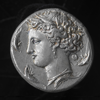

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Syracuse dekadrachm, an exquisite coin from the late 5th century BCE, renowned for its intricate artistry and high relief, created by master artisans such as Kimon and Euinatos. This piece has fascinated collectors for over two millennia, prompting inquiries into the techniques the ancient Greeks employed to achieve such intricate designs without modern technology. A notable admirer of this coin was Theodore Roosevelt, the American president known for his reformative policies. His frustration with the mundane appearance of contemporary coins led him to advocate for more artistic currency, prompting him to compare modern coins unfavorably to classical masterpieces like the dekadrachm. H

/workspace/my_utils.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  report_df = pd.concat([report_df, data_df], ignore_index=True)


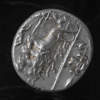

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Syracuse dekadrachm, a captivating silver coin from the late 5th century BCE, renowned for its intricate artistry and high relief, created by master artisans such as Kimon and Euinatos. The coin has fascinated collectors for over two millennia, raising questions about the techniques the ancient Greeks employed to achieve such intricate designs without modern technology. A notable admirer of this coin was Theodore Roosevelt, the American president known for his reformative policies. His frustration with the mundane design of contemporary coins led him to advocate for more artistic currency, prompting him to compare modern coins unfavorably to classical masterpieces l

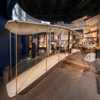

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Wright Flyer, the first successful powered aircraft to carry a pilot, created by aviation pioneers Wilbur and Orville Wright in 1803. The Flyer is powered by a 12-horsepower engine and utilizes a sprocket-and-chain transmission to turn its pusher propellers. Its historic first flight occurred at Kitty Hawk, North Carolina, where it traveled 36 meters (120 feet) in just 12 seconds with Orville at the controls. The Wright brothers' groundbreaking work during four years of research not only led to this remarkable flight but also established key principles of modern aeronautical engineering, including the use of wind tunnels in design experimentation.
==> Ground truth answer: This exhibit 

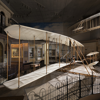

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Wright Flyer, the first successful powered aircraft to carry a pilot, created by aviation pioneers Wilbur and Orville Wright. The Flyer made its historic first flight on December 17, 1903, at Kitty Hawk, North Carolina, achieving a distance of 36 meters (120 feet) in just 12 seconds with Orville at the controls. The Wright brothers' groundbreaking work during four years of research not only led to this remarkable flight but also established key principles of modern aeronautical engineering, including the use of wind tunnels in design experimentation.
==> Ground truth answer: The exhibit features the iconic 1903 Wright Flyer, a pioneering aircraft that marked the daw

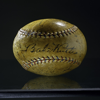

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an autographed baseball from the 1926 New York Yankees, prominently signed by Babe Ruth and Lou Gehrig. Ruth, a celebrated Hall of Famer, and Gehrig, who made history with his remarkable consecutive game record, are both pivotal figures in baseball lore. Gehrig's battle with amyotrophic lateral sclerosis (ALS), often referred to as Lou Gehrig's disease, showcased his remarkable character and inspired many. The baseball itself is made from a cork center, wool layers, and a horsehide cover, with dimensions of 3 inches in diameter. Although this artifact is not currently on display, it is part of the National Museum of American History's collection, generously donated by the Elliot Spencer fa

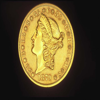

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a unique gold coin minted by the United States Mint in Philadelphia in 1879, cataloged as Judd 1643. The coin presents a Liberty head facing left on its obverse, with the date inscribed below and the circumference detailing the weight and fineness. On the reverse, an eagle is depicted, but it notably includes the Latin motto "DEO EST GLORIA" instead of the usual "IN GOD WE TRUST." This design was inspired by a broader initiative to enhance the international appeal of American coins, which also led to the introduction of the four-dollar gold Stella coin. Among the nine known examples of this pattern, this particular piece is currently not on display. It measures .2 cm by 3.4 cm and is part 

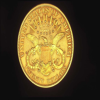

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a unique gold coin produced by the United States Mint in Philadelphia, showcasing a design that incorporates Liberty's head on the obverse and an eagle, emblazoned with the Latin motto "DEO EST GLORIA," on the reverse. This design was inspired by a broader initiative to enhance the international appeal of American coins, which also led to the introduction of the four-dollar gold Stella coin. Among the nine known gold pieces of this design, the one in question dates back to 1879 and is currently not on display. It measures .2 cm by 3.4 cm and is part of the National Museum of American History's National Numismatic Collection.
==> Ground truth answer: This exhibit highlig

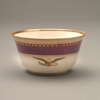

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Abraham Lincoln's coffee cup, a poignant artifact from 1887, which was gifted to the Smithsonian's National Museum of American History by Lincoln Isham, the great-grandson of President Lincoln. The cup holds a historical story, as it was left behind by Lincoln on the evening of April 14, 1865, just before he attended Ford's Theatre for the last time. A diligent White House servant preserved this cup after witnessing the President depart, understanding its potential historical significance. Years later, Captain D.W. Taylor gifted the cup to Robert Todd Lincoln, Lincoln's eldest son, who kept it as a family heirloom. The cup is made of ceramic and features a striking design in purple with wh

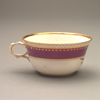

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Abraham Lincoln's coffee cup, a poignant artifact from 1887, which was gifted to the Smithsonian's National Museum of American History by Lincoln Isham, the great-grandson of President Lincoln. The cup holds a historical story, as it was left behind by Lincoln on the evening of April 14, 1865, just before he attended Ford's Theatre for the last time. A diligent White House servant preserved the cup after witnessing the President depart, understanding its potential historical significance. Years later, Captain D.W. Taylor gifted the cup to Robert Todd Lincoln, Lincoln's eldest son, who kept it as a family heirloom. The cup is made of ceramic and features elegant purple w

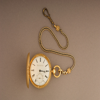

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an exquisite watch that belonged to Abraham Lincoln, which he acquired in the 1850s from Springfield jeweler George Chatterton. While Lincoln was not known for his vanity, this watch served as a notable emblem of his success in his legal career. The movement was crafted in Liverpool, a center for watch manufacturing, while the case was made by an unknown American manufacturer. The watch is recognized for its superior movement, which can keep time with remarkable accuracy when properly maintained. The movement is equipped with a 18K gold case of the highest standard, showcasing exceptional quality. A fascinating story accompanies this watch: during a repair on April 12, 1861, watchmaker Jon

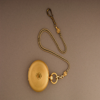

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable artifact: Abraham Lincoln's gold pocket watch, which he acquired in the 1850s from Springfield jeweler George Chatterton. While Lincoln was not known for his vanity, this watch served as a notable emblem of his success in his legal career. The movement was crafted in Liverpool, a center for watch manufacturing, while the case was made by an unknown American manufacturer. The watch is recognized for its superior quality, with a movement that can keep time with remarkable accuracy when properly maintained. A fascinating story accompanies this watch: during a repair on April 12, 1861, watchmaker Jonathan Dillon engraved a message regarding the Confederate atta

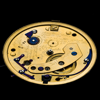

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Could you provide an overview of what is on display here?'}]}
==> User message + assistant prompt (text): User:<image>Could you provide an overview of what is on display here?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an extraordinary watch that belonged to Abraham Lincoln, which he acquired in the 1850s from Springfield, Illinois jeweler George Chatterton. While Lincoln was not known for his vanity, this watch served as a notable emblem of his success in his legal career. The movement was crafted in Liverpool, a center for watch manufacturing, while the case was made by an unknown American manufacturer. The watch is recognized for its superior movement, which can keep time with remarkable accuracy if well-maintained. The movement is equipped with a 18K gold case of the highest standard. A fascinating story accompanies this watch: during a repair on 

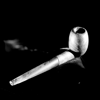

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Albert Einstein's pipe, dating back to approximately 1948, which serves as a testament to the physicist's personal and scholarly identity. Renowned for his groundbreaking theory of relativity and his Nobel Prize, Einstein is also remembered for his distinctive appearance, prominently displaying his pipe. Although he reduced his smoking in his later years due to health concerns, he could not relinquish the enjoyment of holding a pipe. This particular pipe bears the marks of his long-term use, evident in the hole worn into its bit. The pipe was gifted to Gina Plunguian, a close admirer of Einstein, before being acquired by the Smithsonian in 1979. It is part of a larger collection of over 1,

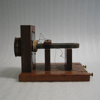

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit at the National Museum of American History focuses on the revolutionary invention of the telephone by Alexander Graham Bell. He received the first patent for this groundbreaking device on March 7, 1876, and within days, on March 10, he made the first successful communication with his assistant, Thomas Watson. Among the key artifacts on display is one of the two telephones used during a demonstration between Boston and Salem on November 26, 1876. This particular device features an iron diaphragm and two electromagnets, distinguishing it from other telephones in the Smithsonian's collection, which typically have wooden covers. Acquired from the American Telephone & Telegraph Co. in 1923, this telepho

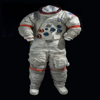

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Apollo 17 spacesuit, an iconic piece of history from the final Apollo mission that landed on the moon in December 1972. The mission was launched on December 7, 1972, by a Saturn V rocket and included a notable crew: Commander Eugene Cernan, command module pilot Ron Evans, and lunar module pilot Harrison Schmitt, who was the first geologist to walk on the moon. While Evans remained in the command module, Cernan and Schmitt landed the lunar module "Challenger" in the Taurus-Littrow region, where they engaged in three moonwalks over three days, collected 110 kilograms of lunar samples, and drove a lunar rover for 35 kilometers. Their mission concluded with a Pacific Ocean landing on Decem

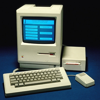

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Apple "Classic" Macintosh Personal Computer, which made its debut in January 1984. Apple Inc. introduced a graphic user interface that allowed users to interact with their computers through visual icons instead of traditional command lines. This innovation was inspired by concepts from Xerox's Palo Alto Research Center but was successfully commercialized by Apple, which famously promoted the Macintosh with a memorable Super Bowl XVIII advertisement, pricing it around $2,500. The original model came with just 128K of RAM, but the release of the Macintosh 512 KB, affectionately known as "Fat Mac," in September 1984, provided users with enhanced capabilities thanks to its 512 KB of RAM. T

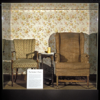

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the historic upholstered wing chair that belonged to the character Archie Bunker, played by Carroll O'Connor in the landmark sitcom "All in the Family." The chair, adorned with a wooden frame and upholstered in a vibrant orange-yellow woven fabric, is believed to have been made in the 1940s, although the exact maker and date remain unknown. It was procured from a thrift store in Southern California and was a key piece in the show until a reproduction was created for the final season after the original was donated to the Smithsonian. "All in the Family," which aired from 1971 to 1979, was a pioneering sitcom that tackled pressing social issues, making it a cultural phenomenon of its time. T

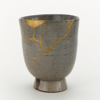

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a stunning tea bowl from the 17th century, belonging to the White Satsuma ware genre, originating from Kagoshima prefecture, Japan. The bowl, made from stoneware with a clear, crackled glaze, showcases the artistry of kintsugi, a traditional Japanese repair technique that highlights rather than conceals damage. Kintsugi employs lacquer made from tree sap, which is toxic in its liquid form but transforms into a safe and water-resistant material upon curing. This process not only ensures the bowl remains functional but also enhances its aesthetic appeal with golden reinforcements in the cracks. The technique has been utilized in Asian ceramics since prehistoric times, but its decorative appl

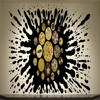

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the work of Yinka Shonibare, an influential artist born in London in 1962. The centerpiece consists of 25 circular canvases of varying sizes, strategically placed over a large ink splatter pattern applied with a template. Each canvas showcases foliate patterns in black and gold, painted on the edges or surfaces of Dutch wax printed fabrics. Shonibare's transition from grid-based paintings to these dynamic forms reflects his engagement with the techniques of Jackson Pollock, creating a playful yet thought-provoking commentary on cultural and artistic intersections. The splatter effect is a nod to the techniques of Jackson Pollock, while the foliate patterns evoke the rich oil resources of A

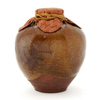

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a captivating tea-leaf storage jar from the 17th century, belonging to the White Satsuma ware genre, originating from Kagoshima prefecture, Japan. The jar, made from stoneware and adorned with a distinctive orange-yellow glaze, showcases the artistry of kintsugi, a traditional Japanese repair technique that highlights rather than conceals damage. Kintsugi employs lacquer made from tree sap, which is toxic in its liquid form but transforms into a safe and water-resistant material upon curing. This process not only ensures the jar remains functional but also enhances its aesthetic appeal with golden reinforcements in the cracks. The technique has been utilized in Asian ceramics since prehist

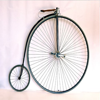

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit at the National Museum of American History features an original 1886 Columbia Light Roadster high-wheel bicycle, celebrating the arrival of spring with a historical artifact that dates back to the 19th century. Manufactured by the Pope Manufacturing Co., the first bicycle producer in the United States, this bicycle was sold for about $135 and is equipped with a 53-inch front wheel comprising 60 spokes and an 18-inch rear wheel with 20 spokes. Additionally, a historic photograph from 1879 accompanies the bicycle, showcasing one of the earliest organized biking tours in America, led by Charles E. Pratt, the first president of the League of American Wheelmen. The Smithsonian's cycling collection, esta

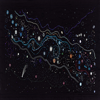

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: The exhibit features the work of Gwich'in artist Margaret Nazon, who was born in Tsiigehtchic, Northwest Territories, Canada, in 1947. Nazon's artistic journey is marked by her transition from a traditional Gwich'in beadwork style to contemporary pieces that incorporate swirling galaxies. This evolution is evident in her early 1990s, when she began creating large-scale works that challenge conventional Gwich'in beadwork. Nazon's artistic process involves a blend of traditional techniques—including carving, embroidery, crochet, and collage—to create intricate designs that are both playful and thought-provoking. The swirling galaxies in her work draw inspiration from the Hubble Space Telescope, showcasing Nazon's

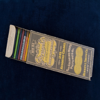

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a historic pack of Crayons from 1903, housed at the Smithsonian's National Museum of American History. Invented by the Binney & Smith Company, these crayons were the brainchild of cousins Edwin Binney and C. Harold Smith, who sought to create a more affordable version of the traditional crayons. By using paraffin wax and non-toxic pigments, they developed a crayon that was safe and accessible for children. The name "Crayola," attributed to Alice Binney, is a combination of the French word for chalk and the term for oily, aptly describing the product. This specific set, aimed at young artists, is one of the earliest produced and includes 28 colors, such as celestial blue and rose pink. The 

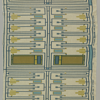

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a striking textile designed by the influential Frank Lloyd Wright, who lived from 1867 to 1959. Created by F. Schumacher & Co., a prominent textile manufacturer from New York, this printed linen showcases a captivating geometric design characterized by rectangular blocks in light blue and varying shades of olive, all set against an off-white background. The dimensions of this textile are 120 cm by 57.5 cm (47 1/4 in. by 22 5/8 in.), with a repeat height of 63.5 cm (25 in.). Attached to the upper back are samples of five alternative colorways, showcasing the versatility of the design. This piece was gifted to the museum by Mr. and Mrs. Burton Tremaine in 1956 and is part of the ongoing rese

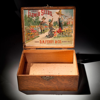

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an antique seed box from the 1890s, belonging to D.M. Ferry & Co., and is part of the Smithsonian's National Museum of American History collection. In the 19th century, seed packets were typically arranged in wooden boxes, adorned with colorful labels, serving as effective marketing tools on store counters. This particular seed box is significant as it represents the innovative “commission box” design, which revolutionized retail display methods. Acquired by the Smithsonian in 1986, it is part of a larger collection of over 10,000 artifacts that highlight the evolution of advertising techniques in the gardening industry. Seed companies like D.M. Ferry & Co. also engaged with amateur garden

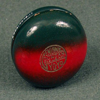

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit at the Smithsonian's National Museum of American History features a captivating story of the yo-yo, a toy that gained widespread appeal in America, largely due to the efforts of Donald F. Duncan Sr., a businessman from Chicago. The story begins in 1928 when Duncan discovered the yo-yo in San Francisco, where it was being marketed by Pedro Flores, a Filipino immigrant who had begun producing the toy and naming it “yo-yo,” which translates to “come-come” in his native language. By early 1929, Flores had established his own company and produced over 100,000 wooden yo-yos, understanding the necessity of demonstrating the toy's tricks to entice buyers. Duncan, recognizing the commercial potential, promp

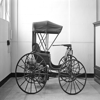

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the 1893-94 Duryea automobile, an iconic piece of American automotive history. As one of the earliest automobiles manufactured in the United States, it was road-tested by Frank Duryea on September 21, 1893, in Springfield, Massachusetts. The Duryea Motor Wagon Company, founded in 1896 by Frank, his brother Charles, and their investors, was the first American enterprise to manufacture and sell automobiles. The vehicle is powered by a one-cylinder, four-cycle gasoline engine, producing four horsepower and features a gear transmission, which replaced the original friction transmission, as well as a spray carburetor and make-and-break ignition. Donated to the Smithsonian's National Museum of A

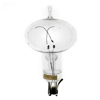

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Edison Light Bulb, a groundbreaking invention from 1879 by Thomas Edison, which revolutionized the way we illuminate our world. Edison's carbon-filament bulb was the first practical electric incandescent lamp, and he famously showcased it to the public during its inaugural demonstration at his laboratory in Menlo Park, New Jersey. The bulb operates by heating its metal filament with electric current, causing it to heat and glow. To ensure its longevity, the filament is enclosed in a glass bulb filled with inert gas, which protects it from oxidation. Edison's contributions to technological innovation are extensive, with a record of 1,093 patents to his credit. He embodies the spirit of 

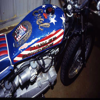

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the iconic 1972 Harley-Davidson XR-750 ridden by Evel Knievel, a daredevil whose daring stunts captivated audiences across the nation. Knievel, born Robert Craig Knievel, was a pioneering entertainer who combined thrilling motorcycle jumps with captivating performances that showcased his skill. His performances, which included aerial jumps over rows of cars, trucks, and buses, gained national attention in the 1960s, and he became a household name in American pop culture. The XR-750, weighing approximately 300 pounds and constructed from steel, aluminum, and fiberglass, was a key part of Knievel's stunts, including the notable jump over 14 Greyhound buses in 1975. This exhibit not only high

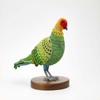

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: The exhibit features Laurel Roth Hope's intriguing work titled “Biodiversity Reclamation Suit: Carolina Parakeet,” created in 2009 and displayed at the Smithsonian American Art Museum. This piece cleverly employs humor to confront the grave issue of species extinction through crocheted suits that allow common rock pigeons to mimic extinct North American birds. While the concept may not restore biodiversity, it certainly invites contemplation on the idea. Hope's artistic process involves traditional techniques such as carving, embroidery, crochet, and collage, which she uses to create intricate animal sculptures that are both playful and thought-provoking. Drawing from her background as a park ranger, she explor

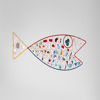

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features "Fish," a striking sculpture by Alexander Calder, created in 1945 and part of the Hirshhorn Museum and Sculpture Garden's collection in Washington, D.C. Calder, who hailed from a family of artists, initially pursued a degree in mechanical engineering before embracing his artistic calling. His journey included freelancing as an illustrator while studying at the Art Students League in New York, which led to his relocation to Paris, where he was inspired by avant-garde artists to create his innovative wire sculptures, which critics referred to as “drawings in space.” In 1931, Calder invented the “mobile,” a kinetic sculpture that moves with the air, and he also conceived “stabiles,” which are

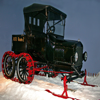

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a 1921 Ford Model T equipped with a snow attachment, illustrating the evolution of rural mail delivery methods in snowy conditions. In the early 1900s, rural mail carriers faced challenges as their vehicles struggled to traverse snowy landscapes. To solve this problem, Virgil White developed a solution by converting cars into snowmobiles, replacing front tires with skis and outfitting the rear with caterpillar treads through his invention known as the Snowbird. This innovation allowed carriers to operate without the need for horses and sleds during winter months. The Ford Model T, a staple of American automotive culture, was particularly favored for its reliability and performance, leading

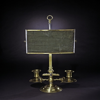

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a significant artifact tied to George Washington, who, after two terms in office, chose to retire rather than run for a third. His Farewell Address, delivered in September 1796, stands as a vital message to the nation, urging Americans to prioritize unity over political divisions. The address was published in The American Daily Advertiser and has been read in the Senate each year since 1896 to honor Washington's birthday. The candle stand, believed to have been used by Washington while composing his address, is a focal point of the exhibit. It is designed with adjustable candlesticks and a reflector lined with green silk, which enhances its illumination from candles. This artifact was pass

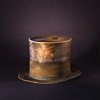

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features President Abraham Lincoln's top hat, a significant artifact displayed at the Smithsonian's National Museum of American History. Renowned for his towering height of 6'4”, Lincoln was not only distinguished by his height but also by his choice of fashion, specifically his high top hats. This particular hat was crafted by J.Y. Davis, a hat maker from Washington, and features a black silk mourning band, a tribute to his son Willie, who died in 1862. Although the exact date of acquisition is unknown, it is historically significant as it was the last hat Lincoln wore on April 14, 1865, before heading to Ford's Theatre. Following his assassination, the War Department took possession of the hat, a

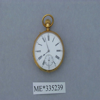

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable artifact: Abraham Lincoln's gold pocket watch, which he acquired in the 1850s from Springfield jeweler George Chatterton. While Lincoln was not known for his vanity, this watch served as a notable emblem of his success in his legal career. The movement was crafted in Liverpool, a center for watch manufacturing, while the case was made by an unknown American manufacturer. The watch is recognized for its superior movement, which can keep time with remarkable accuracy if well-maintained. The movement is equipped with a 18K gold case of the highest standard. A fascinating story accompanies this watch: during a repair on April 12, 1861, watchmaker Jonathan Dillon engraved a message

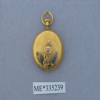

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable artifact: Abraham Lincoln's gold pocket watch, which he acquired in the 1850s from Springfield jeweler George Chatterton. While Lincoln was not known for his vanity, this watch served as a notable emblem of his success in his legal career. The movement was crafted in Liverpool, a center for watch manufacturing, while the case was made by an unknown American manufacturer. The watch is recognized for its superior movement, which can keep time with remarkable accuracy when properly maintained. The case is made from a combination of materials, including copper alloy, silk, and gold plating, with dimensions of 3.7 cm by 1.1 cm by 8.1 cm. This watch was a cherish

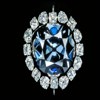

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a stunning diamond necklace by Cartier, Inc., showcasing a single primary gem weighing 45.52 carats. The diamond, with its captivating dark gray-blue color, is skillfully cut into a modified antique cushion shape, which enhances its allure and elegance. This exquisite piece was sourced from India, showcasing not only the beauty of the gem itself but also the rich heritage of jewelry making. It is part of the Mineral Sciences collection, specifically categorized under Gems, and bears the USNM Number NMNH G3551-00. This necklace is a significant artifact for those interested in the artistry and geological significance of gemstones.
==> Ground truth answer: This exhibit features a stunning di

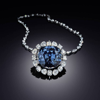

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a stunning diamond necklace by Cartier, Inc., showcasing a single primary gem weighing 45.52 carats. The diamond, with its captivating dark gray-blue color, is skillfully cut into a modified antique cushion shape, which enhances its allure and elegance. This exquisite piece was sourced from India, showcasing not only the beauty of the gem itself but also the rich heritage of jewelry making. It is part of the Mineral Sciences collection, specifically categorized under Gems, and bears the USNM Number NMNH G3551-00. This necklace is a significant artifact for those interested in the artistry and geological significance of gemstones.
==> Ground truth answer: This exhibit sh

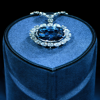

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Could you provide an overview of what is on display here?'}]}
==> User message + assistant prompt (text): User:<image>Could you provide an overview of what is on display here?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a stunning diamond necklace by Cartier, Inc., showcasing a single primary gem weighing 45.52 carats. The diamond, with its captivating dark gray-blue color, is skillfully cut into a modified antique cushion shape, which enhances its allure and elegance. This exquisite piece was sourced from India, showcasing not only the beauty of the gem itself but also the rich heritage of jewelry making. It is part of the Mineral Sciences collection, specifically categorized under Gems, and bears the USNM Number NMNH G3551-00. This necklace is a significant artifact for those interested in the artistry and geological significance of gemstones.
==> Gr

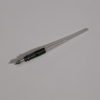

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an Esterbrook pen that holds historical significance as it was used by President Lyndon B. Johnson to sign the Civil Rights Act of 1964 on July 2, 1964. This pen, along with over 70 identical ones, was gifted to influential figures in the Civil Rights Movement. The passage of this legislation was a challenging journey, initially introduced by President John F. Kennedy before his assassination in November 1963. President Johnson's leadership was instrumental in overcoming significant resistance, including a 57-day filibuster in the Senate. The Civil Rights Act represented a crucial first step toward achieving equality, although it required ongoing efforts and additional laws to fully realiz

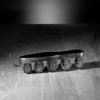

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Volito, an inline skate from 1823, attributed to Robert John Tyers. As the Winter Olympics approach, it's fascinating to reflect on how skaters in the 19th century prepared for competition without modern facilities. The Volito is characterized by its wooden sole and a single row of five wooden wheels, along with a curved iron bar that functions as a basic brake. Its innovative design includes wheels that are larger in the center and smaller at the ends, allowing for improved maneuverability during turns. Although currently not on display, this artifact is part of the National Museum of American History's collection, thanks to a gift from the esteemed 1976 Olympic skater, Sonja Henie. H

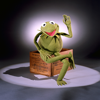

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Kermit the Frog, a character created by Jim Henson that has been a staple of children's television since his debut in 1955 on "Sam and Friends." Kermit is known for his calm demeanor amidst the chaos, particularly on "The Muppet Show" and "Sesame Street." His signature song, “Bein' Green,” reflects on the challenges of his green hue while celebrating his identity. The puppet, made from a blend of materials including synthetic fibers and felt, stands at 27 inches tall and is part of the National Museum of American History's collection, thanks to a gift from Jim Henson Productions.
==> Ground truth answer: This exhibit showcases Kermit the Frog, a beloved character created by Jim Henson, who

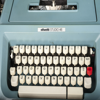

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the typewriter of Octavia Butler, a pioneering science fiction author whose works have left a lasting impact on literature and culture. Butler, who was born on December 14, 1947, in Easton, Pennsylvania, is celebrated for her groundbreaking series such as the Patternist series and the Xenogenesis trilogy, as well as her thought-provoking novels like Parable of the Sower and its sequel, Parable of the Talents. Her writing is characterized by a unique blend of African American history and speculative fiction, contributing to the genre known as Afrofuturism. By centering characters from the African diaspora in her early novels like Wild Seed and Kindred, she inspired many 

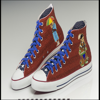

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: The exhibit features "Kiowa Ah-Day," a captivating work by Kiowa artist Teri Greeves, created in 2004. This piece is a pair of sneakers, made from cotton canvas and adorned with intricate beadwork, showcasing the Kiowa artist's unique blend of traditional craftsmanship with modern aesthetics. Measuring 33 x 11 x 15 cm, this artwork is a reflection of the Kiowa culture, rooted in the history of the National Museum of the American Indian. The National Museum of the American Indian acquired this piece from Thirteen Moons Gallery in Santa Fe, New Mexico, highlighting its importance in the dialogue between indigenous art and contemporary expression.
==> Ground truth answer: This exhibit features a remarkable piece t

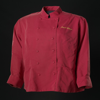

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a compelling collection from the Smithsonian's National Museum of African American History and Culture, generously gifted by Dooky Chase's Restaurant and the esteemed Chef Leah Chase. Renowned as “The Queen of Creole Cuisine,” Chase played a crucial role in showcasing New Orleans Creole cooking worldwide. She famously stated that “We changed the world over a bowl of gumbo,” reflecting on the vital civil rights discussions that took place in her restaurant. Alongside her husband, jazz musician Edgar “Dooky” Chase II, she transformed a modest sandwich shop into a fine-dining establishment, characterized by elegant white tablecloths and important artworks by African American creators. Among t

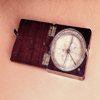

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable pocket compass that dates back to approximately 1804, associated with the Lewis and Clark Expedition. Meriwether Lewis acquired this compass from instrument maker Thomas Whitney in Philadelphia while preparing for the expedition ordered by President Jefferson. The compass is finely crafted with a silver-plated brass rim, a paper dial, and two brass sight vanes, all enclosed in a mahogany box with a leather carrying case. Its history is deeply intertwined with the quest for knowledge and exploration, as Lewis and Clark aimed to chart new territories and establish diplomatic relations with Native American leaders. Although many instruments were lost during their travels, this co

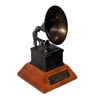

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the 1960 Grammy Award of Bob Newhart, a legendary comedian whose career has spanned over sixty years. Born on September 5, 1929, in Oak Park, Illinois, Newhart is celebrated for his deadpan humor and insightful commentary on societal issues. His debut album, The Button-Down Mind of Bob Newhart, was groundbreaking, being the first comedy LP to top the Billboard charts and winning him a Grammy for Album of the Year, along with the distinction of being the only comedian to win the Grammy for Best New Artist. Newhart's television career includes starring roles in iconic sitcoms like The Bob Newhart Show and Newhart, which have left a lasting impact on the sitcom genre. The exhibit also feature

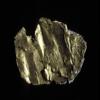

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a significant artifact: a gold nugget from 1848, displayed at the Smithsonian's National Museum of American History. This nugget is believed to be the first piece of gold discovered at Sutter's Mill in California, an event that catalyzed the gold rush. On January 24, 1848, while overseeing the construction of a sawmill, James Marshall discovered a shiny object in the water and, upon inspection, identified it as a thin scale of pure gold. Marshall later presented this find to Capt. Joseph L. Folsom, who documented it as Specimen No. 1, marking it as the first piece of gold discovered in Northern California. By August 1848, this nugget was sent to Washington, D.C., where it was presented to 

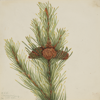

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the watercolor painting "Lodgepole Pine (Pinus Contorta murrayana)" by Mary Vaux Walcott, created in 1921 and measuring 10 x 7 inches. It is part of the Smithsonian American Art Museum's collection, gifted by the artist in 1970. Walcott's journey into botanical illustration was sparked by a request from a botanist to paint a rare arnica flower. After marrying Charles Doolittle Walcott in 1914, they spent summers in the Canadian Rockies, where she produced numerous watercolor studies of local flora. Between 1925 and 1929, her work was published in a five-volume series titled "North American Wild Flowers," and she later illustrated "North American Pitcher Plants" in 1935. Walcott's contribut

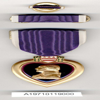

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the esteemed United States Purple Heart, a prestigious military decoration awarded to those who have been wounded or killed while serving. The medal is crafted in a heart shape from gold, showcasing a profile relief of George Washington at its center, set against a vibrant purple enamel background. Above the bust is a shield that highlights Washington's family coat of arms. The reverse side of the medal is inscribed with "FOR MILITARY MERIT," honoring those who have displayed exceptional bravery. It is attached to a silk ribbon that is purple with a white edge stripe. The medal is made from a combination of materials, including copper alloy, silk, gold plating, and a non-magnetic white met

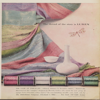

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: The exhibit features the work of Dorothy Liebes, an influential American textile designer whose creations have left a lasting impact on various design domains. Liebes, who was active from the 1930s to the 1960s, is celebrated for her vibrant color palettes and rich textures, which collectively define the aesthetic known as the “Liebes Look.” Throughout her career, she collaborated with renowned architects and designers, including Frank Lloyd Wright and fashion luminaries like Bonnie Cashin, producing iconic pieces that defined mid-century modernism. Although she was recognized during her lifetime, the full extent of her influence on 20th century design is often overlooked today. The exhibit features an advertis

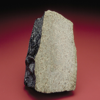

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Nakhla Meteorite Fragment at the Smithsonian's National Museum of Natural History, a remarkable specimen among the thirty-four known Martian meteorites. The Nakhla meteorite fell to Earth on June 28, 1911, in Alexandria, Egypt, where it was observed exploding in the atmosphere before breaking into about forty fragments, with a total weight of 22 pounds. Many of these fragments were found buried up to a meter deep in the ground. The Smithsonian received two samples shortly after the fall, and in 1962, it added a 480-gram fragment, bringing the total collection to 650 grams by the 1970s. The Nakhlites, which are igneous rocks rich in augite, formed from basaltic magma approximately 1.3 b

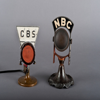

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an RCA Type 50-A microphone, a significant artifact from the era of President Franklin D. Roosevelt's "Fireside Chats." Beginning on March 12, 1933, Roosevelt utilized this innovative form of radio communication to speak directly to the American people, creating a bridge of trust and reassurance during the Great Depression. As the 32nd president, he faced the Great Depression, marked by staggering unemployment and a faltering banking system. Roosevelt's ability to communicate effectively with the public allowed him to engage with listeners as friends, easing their fears and fostering a sense of unity. The microphone, which bears the National Broadcasting Company logos, was preserved by Car

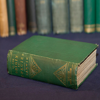

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the groundbreaking work "On the Origin of Species" by Charles Darwin, published in 1859, and is part of the Smithsonian Institution Libraries collection. It commemorates the May 11, 1820, launch of the HMS Beagle, which was instrumental in Darwin's scientific exploration. The Beagle was launched from Woolwich Dockyard in London and underwent several adaptations before embarking on its second survey voyage on December 27, 1831, where Darwin served as a naturalist. During his five-year expedition to South America and the Galápagos Islands, he collected fossils, studied plant specimens, and examined geological formations, which led to his development of the theory of evolution by natural sele

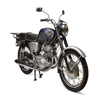

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Robert M. Pirsig's 1966 Honda Super Hawk motorcycle, a key artifact in his influential book, "Zen and the Art of Motorcycle Maintenance: An Inquiry Into Values," published in 1974. The book sold over a million copies in its first year and initiated a widespread reevaluation of how people relate to technology and seek personal balance. Pirsig's inspiration arose from a transformative road trip he took with his son Chris in 1968, during which they traveled 5,700 miles from Minnesota to San Francisco and back. This journey not only strengthened their father-son relationship but also provided Pirsig with deep insights into self-awareness and human experience. The book has sold over 5 million c

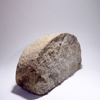

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Plymouth Rock Piece, a historically significant artifact displayed at the National Museum of American History. Traditionally recognized as the landing site of the Mayflower Pilgrims, this rock is closely associated with William Bradford, who led the settlers and served as governor for 30 years. He is also recognized for contributing to the Thanksgiving tradition in America. The rock's history includes a notable event in 1620 when it was moved from its original shore location to the town square, where it split into two halves. The lower half remained in its original spot, while the upper half was taken to the meeting house. By 1774, both halves were rejoined, although several pieces had

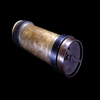

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Pneumatic Mail Container from 1953, housed at the Smithsonian's National Postal Museum. It highlights the remarkable pneumatic tube systems that were installed beneath city streets to facilitate mail transport. Each canister, or carrier, could hold up to 500 letters and was propelled through the tubes by compressed air, reaching an average speed of 35 miles per hour while spinning. At its peak, the system handled an astounding volume of 6 million pieces of mail each day, with five canisters dispatched every minute. The first pneumatic tubes debuted in Philadelphia in 1893, followed by a launch in New York City in 1897, and eventually expanded to other major cities like Boston, Chicago,

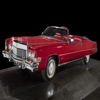

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: The "Rock 'n' Roll Ride" exhibit at the Smithsonian's National Museum of African American History and Culture features a striking 1973 red Cadillac Eldorado that belonged to the legendary Chuck Berry. This exhibit is part of the larger "Musical Crossroads" exhibition, which highlights the cultural impact of music. The Cadillac is particularly significant as it was featured in the 1987 documentary "Hail! Hail! Rock 'n' Roll," directed by Taylor Hackford, which showcases two concerts celebrating Berry's 60th birthday. A memorable moment in the film occurs when Berry drives this car onto the stage of the Fox Theater in St. Louis, a venue that had previously denied him entry as a child due to racial discrimination.

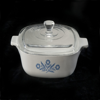

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a notable white casserole dish from CorningWare, dating back to 1965, adorned with the brand's signature blue cornflower design. CorningWare's innovative Pyroceram material was initially developed for military use during World War II, later proving to be an excellent choice for bakeware due to its remarkable properties. This glass-ceramic is non-porous, can withstand rapid temperature shifts, and resists stains and odors, making it a versatile choice for cooking, freezing, and serving. In the 1990s, CorningWare shifted towards ceramic stoneware to meet consumer demand for more colorful and varied designs, but the original glass-ceramic line returned in 2009 due to popul

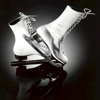

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the autographed ice skates of Sonja Henie, a legendary Norwegian figure skater from the early to mid-20th century. Henie is celebrated for revolutionizing the sport in the late 1920s and 1930s by introducing white leather skates, a striking contrast to the traditional black. She won her first world title in 1927 and went on to achieve ten consecutive titles, captivating audiences with her unique blend of dance and skating. Henie's performances were pivotal in winning her three Olympic gold medals in ladies singles during the 1928, 1932, and 1936 Winter Olympics. Her transition to the professional level saw her become a prominent film star after signing with 20th Century Fox in 1936. In 197

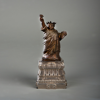

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features one of the earliest models of the Statue of Liberty, often referred to as the American Committee Model. Produced in the United States, this statuette was created in large quantities to finance the construction of the statue's pedestal in New York Harbor. Designed by French sculptor Frédéric-Auguste Bartholdi, the models were made in six-inch and twelve-inch sizes, with the six-inch version priced at one dollar and the twelve-inch version at five dollars. A national newspaper campaign promoted these models, selling the six-inch version for one dollar and the twelve-inch version for five dollars. Richard Butler, a rubber manufacturer from New York, chaired the American Committee that oversaw

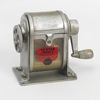

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Dexter Model 3 Pencil Sharpener, dating back to approximately 1920 and manufactured by the Automatic Pencil Sharpener Company (APSCO) in Rockford, Illinois. Constructed from metal, cellulose, and painted wood, this sharpener measures 10.8 x 12.7 x 7 cm (4 1/4 in. x 5 in. x 2 3/4 in.). As the back-to-school season approaches, this artifact may evoke fond memories of classroom experiences. The Dexter sharpener, which evolved from the original introduced in 1914, featured innovative designs with a rotating wheel that accommodated various pencil sizes, enhancing its functionality and appeal. By the 1920s, APSCO had produced a diverse range of sharpeners, showcasing its leadership in the ma

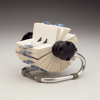

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Rolodex Open Rotary Card File, a staple of office organization that has become iconic over the years. Manufactured by the Rolodex Corporation in the USA, this piece is made from a blend of materials including bent tubular metal, molded plastic, rubber, and paper, with dimensions of 18 x 18 x 16.5 cm (7 1/16 x 7 1/16 x 6 1/2 in.). The Rolodex revolutionized the way business contacts were stored, utilizing a cylindrical design that allows for easy rotation and access to A-Z index cards. Even in the digital age, the Rolodex remains a popular organizational tool, showcasing its enduring appeal. The invention is credited to Arnold Neustadter, a pioneering entrepreneur kn

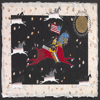

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: The exhibit features the “Lakota Horse Mask,” a captivating work by Jim Yellowhawk, created in 2008 and representing the Cheyenne River Lakota tribe. This piece, made with acrylic on paper and adorned with gold leaf, highlights the profound relationship between Native American tribes and horses, often referred to as the Horse Nation. Horses have been pivotal in Native cultures, serving as both companions in peaceful times and formidable allies in warfare. Historically, horses first appeared in the Americas over 40 million years ago but became extinct until their reintroduction by Columbus in 1493. This artwork is part of the Smithsonian's National Museum of the American Indian collection and is featured in the 

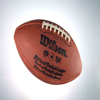

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the iconic Wilson Duke football, which has been the official football of the Super Bowl since Super Bowl II in 1968. The specific football on display was used during Super Bowl XIV on January 20, 1980, at the Rose Bowl in Pasadena, California, where the Pittsburgh Steelers emerged victorious against the Los Angeles Rams with a score of 31-19. This win was historic, marking the Steelers' fourth Super Bowl championship and earning quarterback Terry Bradshaw the Most Valuable Player award for the second consecutive year. The Wilson Duke football is celebrated for its exceptional quality, having been introduced by Wilson Sporting Goods Co. in the early 1940s. While this artifact is part of the

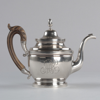

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a beautifully crafted silver teapot by Peter Bentzon, an influential American silversmith active from around 1783 to after 1850. The teapot, created circa 1817-1829, showcases an elegant oval vase shape supported by a spreading pedestal foot, with a gracefully curved spout embellished with an incised patera and a wooden, leaf-capped scroll handle. The hinged domed cover is adorned with an acorn finial, enhancing its decorative appeal. The teapot is engraved with the scripted monogram "MC," while the name "Rebecca Dawson" is engraved along the bottom rim, adding a personal touch to this exquisite piece. Measuring 7 inches in height, 12 inches in width, and 5 inches in depth, it is part of t

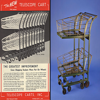

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Telescoping Shopping Cart, an invention that emerged in the 1940s, created by Orla E. Watson from Kansas City, Missouri. As the holiday shopping rush commences, it's fascinating to consider how this design has influenced modern shopping practices. Watson's design allows for carts to nest, thereby optimizing storage space—each cart requiring only one-fifth of the space of a traditional cart when parked. The first iteration of this design was introduced in 1947 at Floyd's Super Market, with subsequent installations at other stores. By 1953, the Telescoping Shopping Cart was a staple of modern retail, showcasing the evolution of shopping convenience.
==> Ground truth answer: The exhibit a

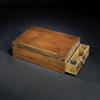

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the portable writing desk of Thomas Jefferson, which he used while drafting the Declaration of Independence in 1776. Designed by Jefferson himself, the desk features a hinged writing surface and a drawer for writing materials. As a delegate from Virginia, he was selected to draft the declaration, which was officially adopted by the Continental Congress on July 4, 1776. The declaration serves as a foundational statement of American independence and has been read in the Senate each year since 1896 to honor the anniversary of the Declaration of Independence. The desk remained a lifelong companion to Jefferson, witnessing his journey as a patriot, diplomat, and president. In 1825, he gifted th

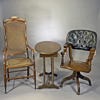

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an important artifact from the Civil War, specifically a chair that was used by General Ulysses S. Grant during the surrender negotiations with General Robert E. Lee on April 9, 1865, at Wilmer McLean's home in Appomattox Court House, Virginia. In this chair, Grant engaged with Lee about the fate of his troops, a moment that effectively signified the end of the Civil War. The chair, made of wood and measuring 37.5 inches in height, is a powerful symbol of this historic event. Following the surrender, Union officers took pieces of the furniture as mementos, with General E. W. Whitaker taking Lee's chair, General Henry Capehart claiming Grant's chair, and General Philip Sheridan retrieving t

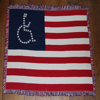

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a hand-altered lap blanket that incorporates the universal access symbol, a tribute to the advocacy efforts of the American Disabled for Attendant Programs Today (ADAPT). The blanket, made from cotton and measuring 129 cm by 95 cm, is adorned with stitched stars, symbolizing the fight for civil rights. ADAPT, founded in 1983, emerged from the post-World War II disability rights movement, which saw individuals with disabilities unite to share their stories and advocate for their rights. The blanket's design not only reflects the struggle for disability rights but also asserts the message that civil rights are universal. Although it is currently not on display, this piece was generously dona

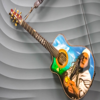

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the guitar of Carlos Vives, a Grammy Award-winning Colombian singer renowned for his vallenato music. Vallenato, a vibrant genre from Colombia's Atlantic coast, blends European instruments like the accordion with poetic lyrics and the rhythmic traditions of the Arhuaco indigenous people. Historically, this music was performed by rural workers and cowboys, but in the 1990s, Vives and other artists began to incorporate pop and rock influences, allowing the genre to resonate with audiences beyond Colombia, including in the United States. The guitar on display, handmade by a Colombian luthier, features an airbrushed image of an Arhuaco and was last played by Vives during a concert at the Holly

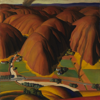

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a compelling painting by Ross Dickinson, an artist whose work emerged from the Public Works of Art Project during the 1930s. Created in California, the piece captures the essence of the state's landscape, characterized by vibrant farmland and the stark, dry hills of the Central Valley. While the farmland is depicted as a promised land for those escaping the Dust Bowl, the hills serve as a stark reminder of the environmental threats that loomed over the area. The small brushfire in the foreground and a larger smoke plume in the distance highlight the constant threat of wildfires during California's dry seasons, showcasing the precariousness of life at that time. Dickinson's work not only re

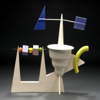

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the work of Peter Shire, an influential artist known for his vibrant ceramics, specifically his Weathervane Teapot. Created in 1981, this piece is characterized by its playful arrangement of shapes, including squares and spheres, alongside swirling rods and hollow tubes. Shire's goal was to challenge and democratize the traditional concept of "tea-time," making it a more inclusive experience. The teapot's design invites viewers to engage with it, raising questions about how to handle it and whether it is even functional. After 1985, Shire shifted his focus to furniture design. This piece is part of the Smithsonian American Art Museum's collection, generously gifted by Donna and John Donald

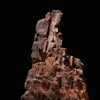

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: The exhibit features the Spotsylvania tree stump, a significant artifact from the Civil War, located at the Smithsonian's National Museum of American History. This stump, which dates back to 1864–65, was once part of a large oak tree located in a serene meadow near Spotsylvania Court House, Virginia. On May 12, 1864, the tranquil setting was transformed into a battlefield as Confederate troops prepared for an assault by Union forces. The ensuing conflict, which would become known as the Bloody Angle, resulted in an estimated 31,000 casualties among the 152,000 soldiers engaged. The stump bears the marks of battle, with several Minié balls still embedded in its wood, serving as a stark reminder of the violence t

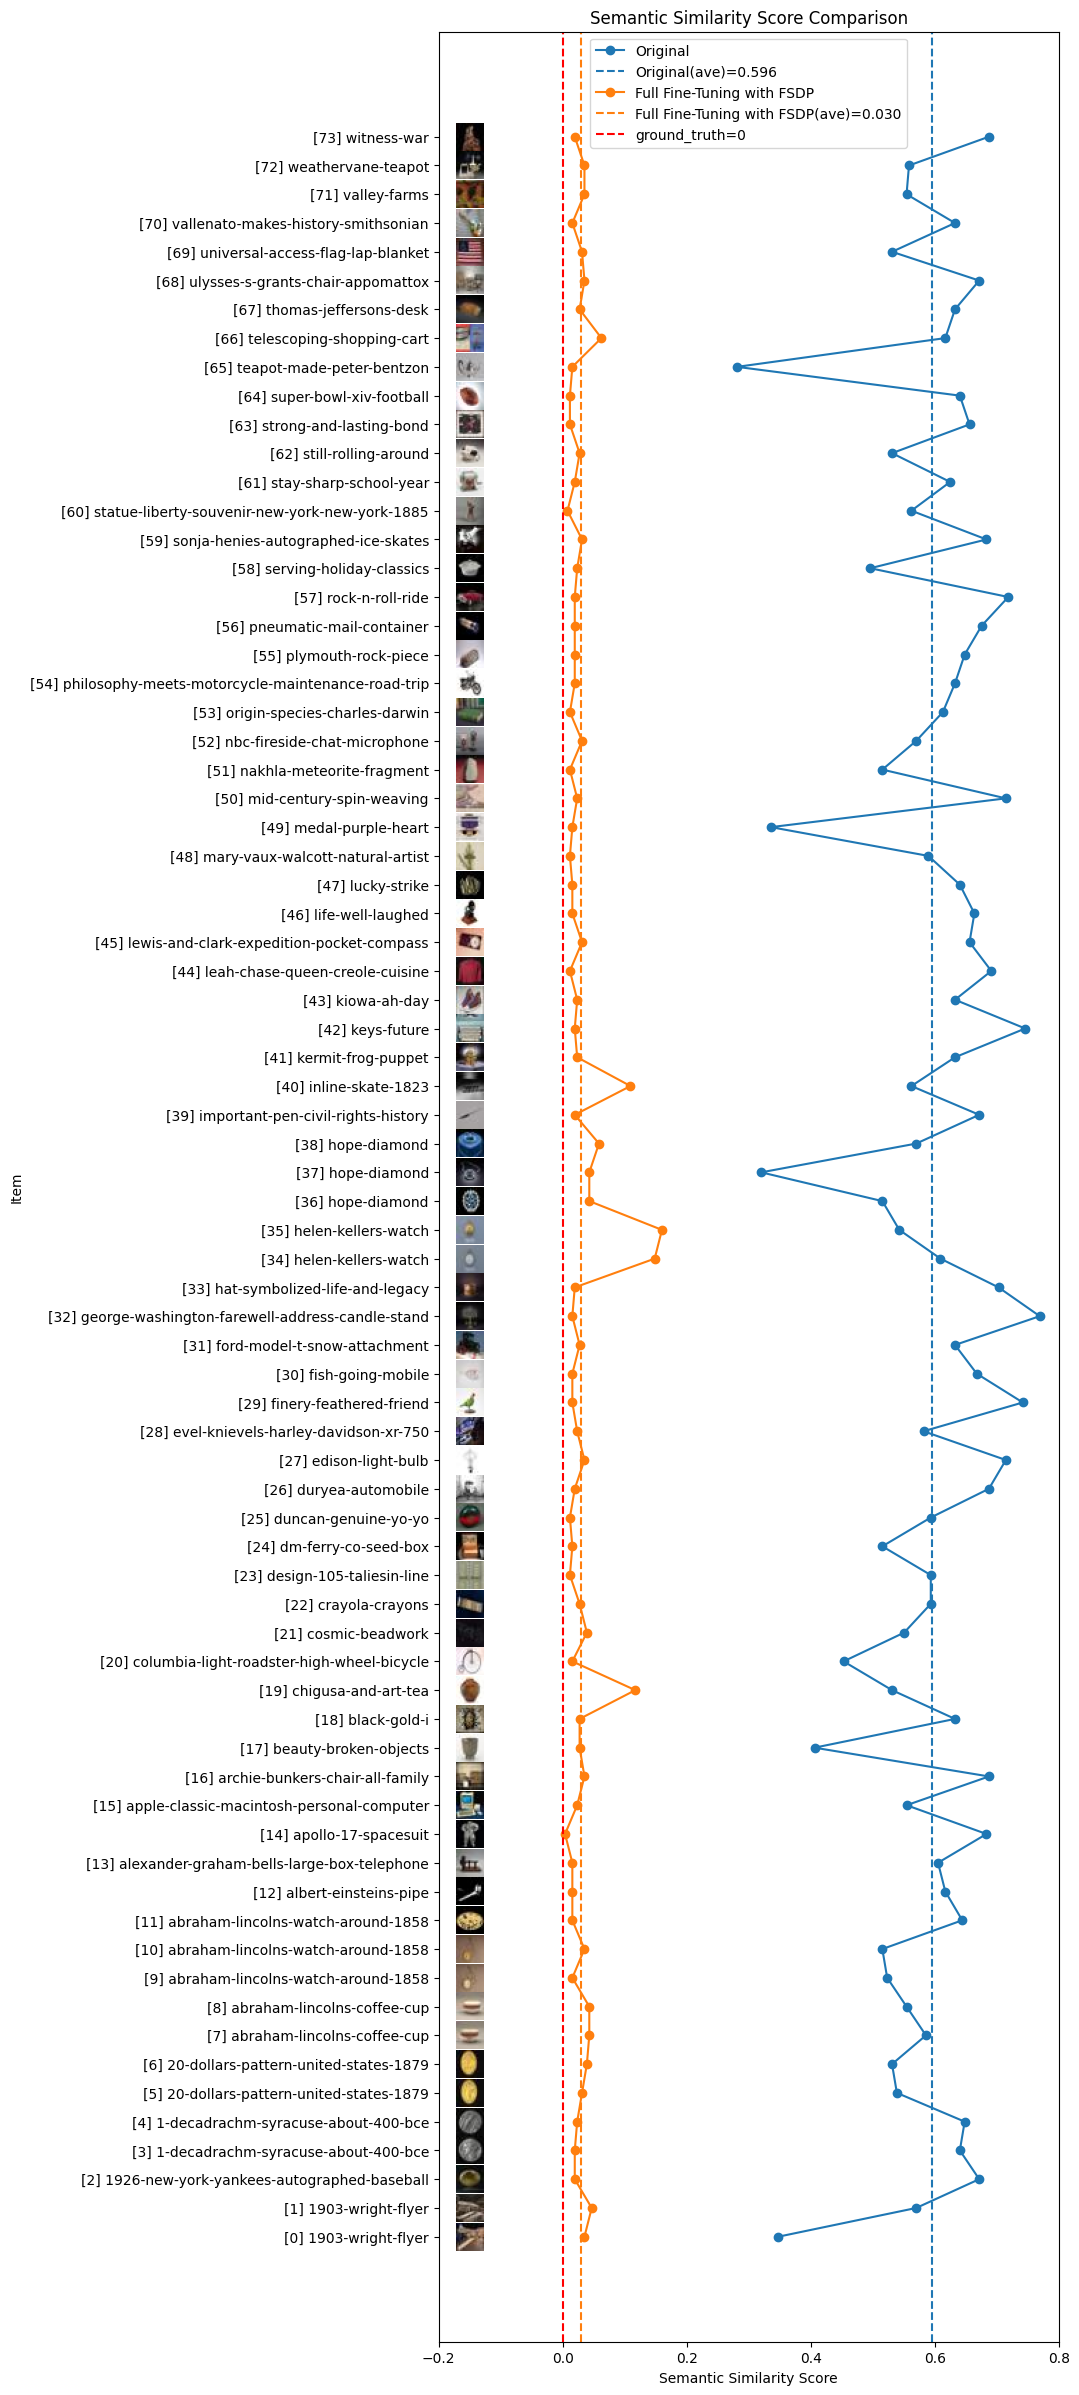

In [2]:
# Load the Hugging Face dataset
dataset = my_utils.load_hf_dataset(hf_path='xugefu/MuseQuest')

# Perform batch inference on the test set and save results to a CSV file
my_utils.batch_inference_model(full_fine_tuning_model, processor, dataset['test'], './results/inference_results/inference_results_after_finetuning.csv', 10)

# Plot similarity scores (original vs. fine-tuned) from the inference CSV files, using thumbnails, and save the plot image locally
my_utils.plot_similarity_scores([('Original', './results/inference_results/inference_results_before_finetuning.csv'),
                                 ('Full Fine-Tuning with FSDP', './results/inference_results/inference_results_after_finetuning.csv')],
                                thumbnail_dir='./results/inference_results/thumbnail',
                                plot_file_name='./results/inference_results/similarity_scores_after_finetuning.jpg')


## 3.4 Save the Fine-Tuned Model Locally  

In [3]:
# Save processor
print(f'==> Saving processor...')
my_utils.print_processor_info_to_file(processor, './results/model_info/updated_processor_info.txt')
processor.save_pretrained(save_directory='./results/finetuned_model')

# Save fine-tuned model
print(f'==> Saving fine-tuned model...')
my_utils.print_model_info_to_file(full_fine_tuning_model, './results/model_info/finetuned_model_info.txt')
my_utils.print_model_parameters_to_file(full_fine_tuning_model, './results/model_info/finetuned_model_parameters.txt')
full_fine_tuning_model.save_pretrained(save_directory='./results/finetuned_model')


==> Saving processor...
==> Printing processor info...
==> Regular token count: 32000, regular+special token count: 32004, bos_token: <s>, eos_token: </s>, pad_token: <pad>
==> For complete processor info, refer to ./results/model_info/updated_processor_info.txt.
==> Saving fine-tuned model...
==> Printing model info...
==> Model type: Idefics2ForConditionalGeneration
==> Model is located on device: cuda:0
==> Model device map: {'': device(type='cpu')}
==> For complete model info (type, architecture, config, generation config, device map), refer to ./results/model_info/finetuned_model_info.txt.
==> Printing model parameters...
model.vision_model.embeddings.patch_embedding.weight (677376, torch.bfloat16, cuda, True)
model.vision_model.embeddings.patch_embedding.bias (1152, torch.bfloat16, cuda, True)
model.vision_model.embeddings.position_embedding.weight (5644800, torch.bfloat16, cuda, True)
model.vision_model.encoder.layers.0.self_attn.k_proj.weight (1327104, torch.bfloat16, cuda, Tru